In [3]:
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import transformers

import re
import os
import sys

import json

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy import stats

from torch.utils.data import DataLoader, SubsetRandomSampler

from transformers import AutoModel, BertModel

from pprint import pprint

In [4]:
sys.path.append(os.path.dirname('/Users/belaneuendorf/Documents/Uni/Masterarbeit/Master_Projects/Master_Thesis/src/'))
sys.path.append(os.path.dirname('/home/neuendo4/Master/Master_Thesis/src/'))
# sys.path.append(os.path.dirname('../src/'))
from utils.datasets import *
from utils.train_utils import *
from utils.constants import *

In [5]:
path_to_data = '../data/'

# test some stuff

## check GHC ratios for scaling num annotators

In [10]:
d = '../data/matching_sizes_data/'
l = os.listdir(d)
l = [a for a in l if 'GHC_' in a]
l = sorted(l, key=lambda x: int(x.split('_')[1]))
l = [x for x in l if int(x.split('_')[1])%2==0]
l

['GHC_6_annos_filtered.csv',
 'GHC_8_annos_filtered.csv',
 'GHC_10_annos_filtered.csv',
 'GHC_12_annos_filtered.csv',
 'GHC_14_annos_filtered.csv',
 'GHC_16_annos_filtered.csv',
 'GHC_18_annos_filtered.csv']

In [266]:
ghc_scal_tuples = [('_'.join(df_path.split('_')[:2]), pd.read_csv(d+df_path)) for df_path in l]

In [256]:
def get_ds_stats_and_ratios(name_df_tuples_list):

    ds_stats = pd.DataFrame()
    ds_indi_ratios = {}

    for df_name, df in name_df_tuples_list:
        annos = get_annos(df)
        n_0 = df.majority.value_counts()[0]
        n_1 = df.majority.value_counts()[1]
        r = n_1 / (n_0+n_1)
        i_0s = df.apply(pd.Series.value_counts).loc[0.0,annos]
        i_1s = df.apply(pd.Series.value_counts).loc[1.0,annos]
        in_0 = i_0s.sum()
        in_1 = i_1s.sum()
        i_r = in_1 / (in_1 + in_0)
        ds_stats.loc[df_name,"1s_ratio_indi"] = f"{round(i_r*100,1)}%"
        ds_stats.loc[df_name,"1s_ratio_majority"] = f"{round(r*100,1)}%"
        ds_indi_ratios[df_name] = i_1s / (i_1s + i_0s)
        
    return ds_stats, ds_indi_ratios

In [267]:
ghc_scal_stats, ghc_scal_ratios = get_ds_stats_and_ratios(ghc_scal_tuples)

In [269]:
ghc_scal_stats

,1s_ratio_indi,1s_ratio_majority
GHC_6,7.4%,8.2%
GHC_8,12.7%,8.6%
GHC_10,12.6%,9.0%
GHC_12,11.8%,8.9%
GHC_14,11.7%,8.8%
GHC_16,12.2%,9.1%
GHC_18,12.3%,9.1%


In [268]:
ghc_scal_ratios

{'GHC_6': 7     0.135093
 4     0.049128
 10    0.025397
 11    0.087025
 12    0.094720
 13    0.048000
 dtype: float64,
 'GHC_8': 0     0.442916
 7     0.136080
 4     0.054088
 8     0.144501
 10    0.022670
 11    0.089646
 12    0.101124
 13    0.052434
 dtype: float64,
 'GHC_10': 0     0.445798
 7     0.135405
 2     0.064000
 4     0.053333
 5     0.171115
 8     0.147523
 10    0.023256
 11    0.093202
 12    0.101197
 13    0.055799
 dtype: float64,
 'GHC_12': 0     0.451717
 7     0.134897
 1     0.040064
 2     0.059466
 4     0.054848
 5     0.160458
 8     0.149802
 10    0.023438
 11    0.090116
 12    0.094025
 13    0.058014
 17    0.078505
 dtype: float64,
 'GHC_14': 0     0.454813
 7     0.131341
 1     0.036603
 2     0.060538
 3     0.126638
 4     0.052679
 5     0.161589
 8     0.146274
 9     0.101180
 10    0.023572
 11    0.087971
 12    0.090744
 13    0.058348
 17    0.089226
 dtype: float64,
 'GHC_16': 0     0.457798
 7     0.138605
 1     0.035422
 2     0.

In [ ]:
for ds in l:
    with

# helper function

In [6]:
# k = number of comments per annotator
# l = number of comments per post

def get_annos(df, is_sc=False):
    if not is_sc:
        annos = [y for y in df.columns if re.fullmatch(r'[0-9]*',y)]
    else:
        annos = [y for y in df.columns if y!='parent_id']
    return(annos)

def df_only_annos(df):
    return(df[get_annos(df)])

def get_max_anno(df):
    annos = get_annos(df)
    only_annos_df = df[annos]
    max_anno = max(only_annos_df.columns.tolist(), key=lambda col: df[col].count())
    return max_anno

def get_min_anno(df):
    annos = get_annos(df)
    only_annos_df = df[annos]
    min_anno = min(only_annos_df.columns.tolist(), key=lambda col: df[col].count())
    return min_anno

def remove_empty_rows(df):
    annos = get_annos(df)
    return df[~df[annos].isna().all(axis=1)]

def remove_max_anno(df, k):
    max_anno = get_max_anno(df)
    return_df =  df.drop(max_anno, axis=1)
    return_df = remove_empty_rows(return_df)
    return return_df

def remove_min_anno(df, k):
    min_anno = get_min_anno(df)
    return_df =  df.drop(min_anno, axis=1)
    return_df = remove_empty_rows(return_df)
    return return_df

def reduce_to_num_annos_by_remove_min(df, num_annos, is_sc=False):
    annos = get_annos(df, is_sc=is_sc)
    while len(df[annos].columns) > num_annos:
        min_anno = get_min_anno(df)
        df = df.drop(min_anno, axis=1)
        annos = get_annos(df, is_sc=is_sc)
    return remove_empty_rows(df)

def reduce_to_num_annos_by_remove_max(df, num_annos):
    annos = get_annos(df)
    while len(df[annos].columns) > num_annos:
        max_anno = get_max_anno(df)
        df = df.drop(max_anno, axis=1)
        annos = get_annos(df)
    return remove_empty_rows(df)

def reduce_to_l(df,l):
    annos = get_annos(df)
    filter_df = df[annos].count(axis=1) >= l
    return df[filter_df]

def reduce_df_to_k(df,k):
    return df.dropna(thresh=k, axis='columns')

def reduce_df_to_k_l(df,k,l):
    (n,m) = df.shape
    is_change = True

    while is_change:
        df = reduce_df_to_k(df,k)
        df = reduce_to_l(df,l)
        is_change = (n,m) > df.shape
        (n,m) = df.shape

    return df

def reduce_df_to_k_l_num_annos(df, k, l, num_authors, use_min=False): # k = minimum num of annotations per annotator, l = number of annotators
    df = reduce_df_to_k(df, k)
    annos = get_annos(df)

    while len(df[annos].columns) > num_authors:
        if use_min:
            df = remove_min_anno(df, k)
        else:
            df = remove_max_anno(df, k)
        df = reduce_to_l(df,l)

    assert len(df[annos] == num_authors)
    return df

def reduce_df_to_k_num_annos_num_post(df, k, l, num_authors, num_posts): # k = minimum num of annotations per annotator, l = number of annotators
    df = reduce_df_to_k(df, k)
    df =  reduce_to_num_annos_by_remove_min(df, num_authors)

    is_change = True
    while is_change:
        margin = min(20,len(df) - num_posts)
        crit_anno_filter = df.count() <= k + margin
        crit_annos = crit_anno_filter.index[crit_anno_filter].tolist()
        max_anno = get_max_anno(df)
        save_df = df[df[crit_annos].isna().all(axis=1)]
        new_df = df[~df.index.isin(save_df[~save_df[max_anno].isna()][:margin].index)]
        #margin = min(100,len(df) - num_posts)
        is_change = len(new_df) < len(df)
        df = new_df
        
    return df

In [7]:
def get_n_posts_annos_of_ks(df, k_list, l=1):
    shapes = []
    for k in k_list:
        df = reduce_df_to_k_l(df,k,l)
        shapes.append(df.shape)
    n_posts, n_annos = zip(*shapes)
    return (n_posts, n_annos)

In [8]:
def remove_once_threshold_posts_frequent_annos(df, target_number, min_number_annotations, anno_list, margin):
    threshold = min_number_annotations + margin
    max_anno_val = df[anno_list].count().sort_values()[-1]
    filter = df.count() <= threshold
    crit_annos = filter.index[filter].tolist()
    filter_df = df[crit_annos].dropna(axis=0, how='all')
    filtered_df = df[~df.index.isin(filter_df.index)]
    remove_amount = min(margin, max_anno_val-threshold, len(df)-target_number)
    return_index = filtered_df[remove_amount:].index.append(filter_df.index)
    return df[df.index.isin(return_index)]

def remove_all_posts_until_target(df, target_number, min_number_annotations, margin_select_ratio=2/3):
    anno_list = get_annos(df)
    number_of_margins = 1

    is_change = True
    while (len(df) >= target_number) and is_change:
        anno_counts = df[anno_list].count().sort_values()
        margin = anno_counts[int(len(anno_counts)*margin_select_ratio)]-min_number_annotations
        is_change = False
        while True:
            filtered_df = remove_once_threshold_posts_frequent_annos(df, target_number, min_number_annotations, anno_list, margin)
            if len(df) <= len(filtered_df):
                number_of_margins +=1
                break
            df = filtered_df
            if not is_change:
                is_change = True

    return df, number_of_margins


def boil_down_df(df,k,l, number_annotators, num_posts, margin_select_ratio=2/3):
    df = reduce_df_to_k_l_num_annos(df,k,l, number_annotators)
    df, margins = remove_all_posts_until_target(df,num_posts,k,margin_select_ratio)
    return df, margins

    

# create funkes embeddings for a MT dataset:

In [44]:
df = pd.read_csv('../data/ConvAbuse_data/ConvAbuse_8_annos_filtered.csv')
annos = get_annos(df)

In [53]:
pos_list = list(df[df[annos[0]] == 1].text)

In [165]:
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-cased")

In [278]:
x = torch.rand(20,384)


RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

In [286]:
tokenized = tokenizer.pad(tokenizer(list(data.text), truncation=True))
tokenized = {k: torch.tensor(v) for k, v in tokenized.items()} 

In [291]:
torch.rand(384)

tensor([0.1691, 0.1124, 0.3855, 0.5975, 0.4095, 0.3433, 0.0222, 0.8175, 0.2061,
        0.1769, 0.1535, 0.4811, 0.6575, 0.3102, 0.8456, 0.0053, 0.7534, 0.1940,
        0.5258, 0.4351, 0.8496, 0.2267, 0.0817, 0.2679, 0.3389, 0.5942, 0.2074,
        0.7155, 0.9466, 0.9644, 0.2372, 0.5192, 0.2560, 0.4224, 0.0456, 0.8790,
        0.0119, 0.5643, 0.8380, 0.6872, 0.0764, 0.8694, 0.5908, 0.6942, 0.1197,
        0.6191, 0.9545, 0.5684, 0.9813, 0.4994, 0.8844, 0.2958, 0.7742, 0.8997,
        0.5065, 0.5351, 0.4927, 0.8825, 0.7764, 0.5072, 0.3645, 0.4595, 0.6768,
        0.5767, 0.4540, 0.6192, 0.6845, 0.3452, 0.9257, 0.1373, 0.2434, 0.7387,
        0.4395, 0.0837, 0.2753, 0.0255, 0.3774, 0.1126, 0.5977, 0.4107, 0.6521,
        0.7870, 0.9246, 0.0715, 0.6365, 0.2803, 0.0614, 0.2513, 0.8706, 0.9559,
        0.4682, 0.9207, 0.0424, 0.7220, 0.0972, 0.2212, 0.3929, 0.5964, 0.0190,
        0.2248, 0.4663, 0.1170, 0.1623, 0.9614, 0.4749, 0.2829, 0.2479, 0.4683,
        0.1854, 0.2522, 0.6815, 0.6656, 

In [289]:
model(**tokenized, batched=True)

TypeError: BertModel.forward() got an unexpected keyword argument 'batched'

In [159]:
embeddings = model.get_input_embeddings()
embeddings

Embedding(30522, 384, padding_idx=0)

In [174]:
embeddings(torch.tensor(30521))

tensor([-0.0484,  0.0109,  0.0187,  0.0157, -0.0551,  0.0528, -0.0113, -0.0016,
         0.0084,  0.0636,  0.0129,  0.0884, -0.0084,  0.0251,  0.0054, -0.0042,
         0.0084,  0.0114, -0.0134, -0.0153,  0.0221,  0.0221, -0.0131, -0.0130,
         0.0364, -0.0191,  0.0142, -0.0240,  0.0091, -0.0266,  0.0008,  0.0063,
        -0.0019,  0.0121, -0.0443,  0.0093,  0.0032, -0.0657, -0.0053, -0.0296,
        -0.0222, -0.0196,  0.0190, -0.0075,  0.0299, -0.0155, -0.0223,  0.0349,
        -0.0406, -0.0031,  0.0093, -0.0322,  0.0093, -0.0304,  0.0173, -0.0062,
        -0.0237, -0.0072, -0.0072,  0.0138, -0.0178,  0.0192, -0.0273,  0.0491,
         0.0089,  0.0075, -0.0038,  0.0882,  0.0071, -0.0092, -0.0069,  0.0006,
        -0.0325, -0.0327,  0.0171,  0.0374, -0.0424,  0.0082, -0.0038, -0.0363,
        -0.0092, -0.0489, -0.0431,  0.0059,  0.0414,  0.0334,  0.0560, -0.0079,
         0.0200,  0.0185, -0.0143,  0.0299, -0.0325,  0.0048, -0.0068, -0.0381,
        -0.0136,  0.0197, -0.0152, -0.03

In [180]:
model.resize_token_embeddings(30530)

Embedding(30530, 384)

In [186]:
embeddings = model.get_input_embeddings()
embeddings(torch.tensor(30522)).

AttributeError: 'Tensor' object has no attribute 'replace'

In [189]:
embeddings.weight[30521,:] = torch.tensor([1,2,4])

RuntimeError: The expanded size of the tensor (384) must match the existing size (3) at non-singleton dimension 0.  Target sizes: [384].  Tensor sizes: [3]

In [ ]:
torch.nn.modules.sparse.Embedding

In [167]:
type(embeddings)

torch.nn.modules.sparse.Embedding

In [190]:
e = model.get_input_embeddings()

In [244]:
model.embeddings.weights[3,:]

AttributeError: 'BertEmbeddings' object has no attribute 'weights'

In [267]:
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

idx = 10

comp_emgedding = torch.zeros(384)
with torch.no_grad():
    model.embeddings.word_embeddings.weight[idx] = comp_emgedding
    

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [209]:
e(torch.tensor(2))

True

In [233]:
t = torch.zeros(384)
t.requires_grad = True

e.weight[5,:].data = t

In [240]:
e.weight[5,:] = t

RuntimeError: a view of a leaf Variable that requires grad is being used in an in-place operation.

In [228]:
e(torch.tensor(5)).data

tensor([-1.2886e-02, -3.1525e-02,  4.0649e-02,  1.0201e-02, -4.9438e-02,
         3.2532e-02, -1.8951e-02,  1.3359e-02,  3.0575e-03,  5.1575e-02,
        -1.4122e-02,  3.7628e-02, -3.3600e-02,  2.2263e-02, -4.1565e-02,
         1.0368e-02, -1.6724e-02,  6.2027e-03, -9.5520e-03, -3.1471e-03,
         3.2787e-03,  1.3550e-02,  2.2984e-03,  4.2462e-04,  4.7028e-02,
         2.4033e-02, -2.4048e-02,  5.3940e-03,  6.4812e-03, -1.9714e-02,
        -2.4734e-02, -3.4657e-03,  1.0559e-02, -6.7825e-03, -3.4637e-02,
         2.5146e-02,  1.9348e-02, -3.7048e-02,  2.2552e-02, -2.1439e-02,
        -9.9564e-03, -3.5492e-02,  2.6215e-02,  2.0996e-02,  1.1024e-02,
         5.1804e-03, -1.0155e-02,  7.1335e-03, -1.7197e-02, -7.1869e-03,
        -1.2703e-02,  6.5947e-04, -1.5068e-02, -2.1820e-03, -3.0613e-03,
        -9.6178e-04, -3.3905e-02, -2.2812e-02,  1.1383e-02,  3.0197e-02,
        -1.3954e-02,  4.4518e-03, -2.3056e-02, -1.0162e-02,  2.1088e-02,
        -2.0416e-02, -1.2199e-02,  2.8503e-02,  1.2

In [210]:
torch.tensor(1).requires_grad

False

In [ ]:
model.set_input_embeddings

In [161]:
model.embeddings

Embedding(30522, 384, padding_idx=0)

In [128]:
tokenized = tokenizer.pad(tokenizer(pos_list, truncation=True))
tokenized = {k: torch.tensor(v) for k, v in tokenized.items()}

In [130]:
tokenized.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [131]:
len(tokenized['input_ids'])

167

In [132]:
m_res = model(**tokenized)

In [112]:
m_res = model(**tokenized)
p_out = m_res['pooler_output']

In [113]:
p_out.shape

torch.Size([167, 384])

In [120]:
t = torch.mean(m_res['pooler_output'], axis=0)

In [63]:
pos_list_tokenized = [tokenizer.encode]

169

In [140]:
npt = np.array(t.detach())

In [142]:
npt.shape

(384,)

In [145]:
np.concatenate([npt,npt], axis=0).shape

(768,)

In [41]:
# dataframe needs to have shape N x (M (+1)) with N = number of text instances in the dataset, M = number of annotators and +1 because of the column containing the texts
def create_composite_embeddings(df):
    model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2').to(DEVICE)
    tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-cased")

    anno_embeddings = dict()

    for anno in annos:
        neg_list = list(df[df[anno] == 0].text)
        pos_list = list(df[df[anno] == 1].text)
        
        avg_embeddings = dict()
        
        for sentences, name in zip([neg_list, pos_list],['neg', 'pos']):
            tokenized = tokenizer.pad(tokenizer(sentences, truncation=True))
            tokenized = {k: torch.tensor(v).to(DEVICE) for k, v in tokenized.items()} 
            
            m_res = model(**tokenized)
            p_out = m_res['pooler_output'] 
            
            mean = torch.mean(p_out, axis=0)
            mean = np.array(mean.detach())
            avg_embeddings[name] = mean
            
        concatenated = np.concatenate([avg_embeddings['neg'], avg_embeddings['pos']], axis=0)
        
        anno_embeddings[anno] = concatenated
    
    return anno_embeddings    


,Unnamed: 0,id,1,2,3,4,5,6,7,8,text,majority
0,0,0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,"Please go on. [SEP] well, i have a eatproblem ...",0
1,1,1,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,How long have you been on the verge of suicide...,0
2,2,2,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,You are being a bit negative. [SEP] I hate you...,0
3,3,3,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,Will you be travelling in Economy Class? [SEP]...,0
4,4,4,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,Will you be travelling in Economy Class? [SEP]...,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3197,3197,3198,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,Do you wish to hate me? [SEP] How old are you?...,0
3198,3198,3199,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,What city will you be flying from? [SEP] Dubai...,0
3199,3199,3200,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,I'm not sure about your departure airport. Wha...,0
3200,3200,3201,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,Does that question interest you? [SEP] yes [SE...,0


# ArMIS

In [85]:
path_to_data = '../data/ArMIS_data/'
ds_name = 'ArMIS'

## preprocess and transpose

In [86]:
all_df = pd.DataFrame(columns=['text','id'])

for split in ['train','dev','test']:
    with open(f'{path_to_data}{ds_name}_{split}.json') as file:
        d = json.load(file)
    
    for sub_d in d.values():
        idx = len(all_df)
        text = sub_d['text']
        
        assert(text not in list(all_df['text']))
        
        all_df.loc[idx,'id'] = int(idx)
        all_df.loc[idx,'text'] = text
        
        annotators = sub_d['annotators'].split(',')
        labels = [int(l) for l in sub_d['annotations'].split(',')]
        for annotator, label in zip(annotators, labels):
            all_df.loc[idx, annotator] = label

all_df.id = all_df.id.convert_dtypes()

In [87]:
anno_to_id_mapping = {anno: anno.strip('Ann') for anno in [x for x in all_df.columns if 'Ann' in x]}
with open(f'{path_to_data}{ds_name}_anno_to_id_mapping.json','w') as f:
    json.dump(anno_to_id_mapping, f)

In [88]:
all_df = all_df.rename(anno_to_id_mapping, axis=1)

In [89]:
annos = get_annos(all_df)

In [90]:
all_df['majority'] = (all_df[annos].sum(axis=1) / all_df[annos].count(axis=1) > 0.5).astype('int')

In [91]:
all_df

,text,id,1,2,3,majority
0,النسويه يعني نصير رجل قولتك وبعدين اذا الوحده ...,0,0.0,0.0,0.0,0
1,هراء النسويات عمان والمتستر بتضخيم حالات العنف...,1,1.0,0.0,1.0,1
2,بسبب انتشار الفكر النسوي القد ودعوة النسويات ا...,2,1.0,1.0,1.0,1
3,وقال تعالى الن الل احا الل تأملي هذة الأيه,3,0.0,0.0,0.0,0
4,يعني السعوديات صايعات يتنقلو واحد للثاني,4,0.0,0.0,1.0,0
...,...,...,...,...,...,...
938,تخيل مطوع قال ناقصات عقل دين,938,0.0,0.0,0.0,0
939,تخيلي اقول الله ياخذ النساء اذا وحدة زعلت ردت ...,939,0.0,0.0,1.0,0
940,الله يرحمه يغفرله يجعل مثواه الجنه يارب العالم...,940,0.0,0.0,0.0,0
941,مافي الزمن النبي قال زمن الأزمنة يكون النساء أ...,941,0.0,1.0,0.0,0


In [92]:
all_df[annos].value_counts()

1    2    3  
0.0  0.0  0.0    393
1.0  1.0  1.0    224
     0.0  1.0     99
0.0  0.0  1.0     82
1.0  0.0  0.0     62
     1.0  0.0     53
0.0  1.0  0.0     17
          1.0     13
Name: count, dtype: int64

In [93]:
all_df.to_csv(f'{path_to_data}{ds_name}_all_transposed.csv', index=False)

## split

In [94]:
data = pd.read_csv(f'{path_to_data}{ds_name}_all_transposed.csv')

In [95]:
data

,text,id,1,2,3,majority
0,النسويه يعني نصير رجل قولتك وبعدين اذا الوحده ...,0,0.0,0.0,0.0,0
1,هراء النسويات عمان والمتستر بتضخيم حالات العنف...,1,1.0,0.0,1.0,1
2,بسبب انتشار الفكر النسوي القد ودعوة النسويات ا...,2,1.0,1.0,1.0,1
3,وقال تعالى الن الل احا الل تأملي هذة الأيه,3,0.0,0.0,0.0,0
4,يعني السعوديات صايعات يتنقلو واحد للثاني,4,0.0,0.0,1.0,0
...,...,...,...,...,...,...
938,تخيل مطوع قال ناقصات عقل دين,938,0.0,0.0,0.0,0
939,تخيلي اقول الله ياخذ النساء اذا وحدة زعلت ردت ...,939,0.0,0.0,1.0,0
940,الله يرحمه يغفرله يجعل مثواه الجنه يارب العالم...,940,0.0,0.0,0.0,0
941,مافي الزمن النبي قال زمن الأزمنة يكون النساء أ...,941,0.0,1.0,0.0,0


In [96]:
rand_state = SEEDS[0]
df = data

k_fold_train_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_state)
train_split_ids, test_split_ids = next(iter(k_fold_train_test.split(X=df, y=df.majority)))

tr_df_maj = df.iloc[train_split_ids.tolist()]
test_df_maj = df.iloc[test_split_ids.tolist()]

k_fold_test_val = StratifiedKFold(n_splits=4, shuffle=True, random_state=rand_state)
train_split_ids_new, val_split_ids_new = next(iter(k_fold_test_val.split(X=tr_df_maj, y=tr_df_maj.majority)))

val_split_ids = train_split_ids[val_split_ids_new]
train_split_ids = train_split_ids[train_split_ids_new]

tr_df_maj = df.iloc[train_split_ids.tolist()]
val_df_maj = df.iloc[val_split_ids.tolist()]

# tr_df_maj = tr_df_maj[['id']]
# val_df_maj = val_df_maj[['id']]
# test_df_maj = test_df_maj[['id']]

tr_df_maj.to_csv(f'{path_to_data}train_{ds_name.lower()}.csv', index=False)
val_df_maj.to_csv(f'{path_to_data}val_{ds_name.lower()}.csv', index=False)
test_df_maj.to_csv(f'{path_to_data}test_{ds_name.lower()}.csv', index=False)

In [97]:
armis_train = pd.read_csv('../data/ArMIS_data/train_armis.csv')
armis_test = pd.read_csv('../data/ArMIS_data/test_armis.csv')


In [98]:
armis_train['3'].value_counts()

3
0.0    313
1.0    252
Name: count, dtype: int64

## create subsets

In [99]:
anno_counts = data[annos].count(axis=0)

In [100]:
anno_counts

1    943
2    943
3    943
dtype: int64

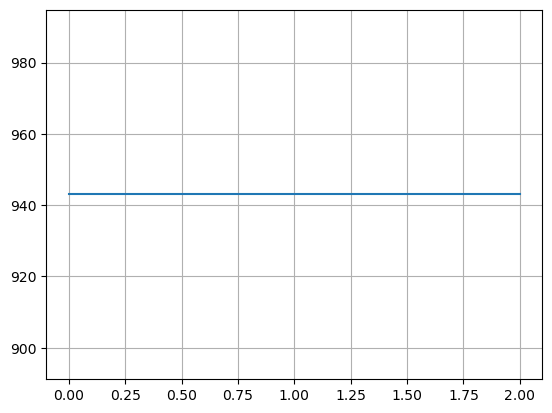

In [101]:
pl = sns.lineplot(sorted(anno_counts, reverse=True))
pl.grid()

In [102]:
subset_list = [3,2,1]

In [103]:
# new algorithm, just num authors

path_to_save = path_to_data

df_copy = data.copy()

for num_annos in subset_list:
    print('#'*50)
    df_copy = reduce_to_num_annos_by_remove_min(df_copy, num_annos)
    
    print(df_copy.shape)
    
    df_copy.to_csv(f'{path_to_data}/{ds_name}_{num_annos}_annos_filtered.csv')

##################################################
(943, 6)
##################################################
(943, 5)
##################################################
(943, 4)


# ConvAbuse

In [37]:
path_to_data = '../data/ConvAbuse_data/'
ds_name = 'ConvAbuse'

## preprocess and transpose

In [38]:
all_df = pd.DataFrame(columns=['text','id'])

for split in ['train','dev','test']:
    with open(f'{path_to_data}{ds_name}_{split}.json') as file:
        d = json.load(file)
        
    for sub_d in d.values():
        idx = len(all_df)
        text = sub_d['text']
        
        assert(text not in all_df['text'])
        
        all_df.loc[idx,'id'] = int(idx)
        all_df.loc[idx,'text'] = text
        
        annotators = sub_d['annotators'].split(',')
        labels = [0 if int(l) >= 0 else 1 for l in sub_d['annotations'].split(',')]
        for annotator, label in zip(annotators, labels):
            all_df.loc[idx, annotator] = label

all_df.id = all_df.id.convert_dtypes()

In [39]:
all_df

,text,id,Ann2,Ann3,Ann7,Ann8,Ann1,Ann6,Ann4,Ann5
0,"{""prev_agent"": ""Please go on."", ""prev_user"": ""...",0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,"{""prev_agent"": ""How long have you been on the ...",1,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,"{""prev_agent"": ""You are being a bit negative.""...",2,NaN,NaN,0.0,NaN,1.0,NaN,NaN,NaN
3,"{""prev_agent"": ""Will you be travelling in Econ...",3,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
4,"{""prev_agent"": ""Will you be travelling in Econ...",4,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
4045,"{""prev_agent"": ""_"", ""prev_user"": ""moron"", ""age...",4045,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN
4046,"{""prev_agent"": ""Why do you not understand?"", ""...",4046,0.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN
4047,"{""prev_agent"": ""Good to know"", ""prev_user"": ""O...",4047,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4048,"{""prev_agent"": ""which city did I get wrong?"", ...",4048,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0


In [40]:
anno_to_id_mapping = {anno: anno.strip('Ann') for anno in [x for x in all_df.columns if 'Ann' in x]}
with open(f'{path_to_data}{ds_name}_anno_to_id_mapping.json','w') as f:
    json.dump(anno_to_id_mapping, f)

In [41]:
all_df = all_df.rename(anno_to_id_mapping, axis=1)

In [42]:
annos = get_annos(all_df)

In [43]:
all_df['majority'] = (all_df[annos].sum(axis=1) / all_df[annos].count(axis=1) > 0.5).astype('int')

In [44]:
all_df

,text,id,2,3,7,8,1,6,4,5,majority
0,"{""prev_agent"": ""Please go on."", ""prev_user"": ""...",0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0
1,"{""prev_agent"": ""How long have you been on the ...",1,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0
2,"{""prev_agent"": ""You are being a bit negative.""...",2,NaN,NaN,0.0,NaN,1.0,NaN,NaN,NaN,0
3,"{""prev_agent"": ""Will you be travelling in Econ...",3,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0
4,"{""prev_agent"": ""Will you be travelling in Econ...",4,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
4045,"{""prev_agent"": ""_"", ""prev_user"": ""moron"", ""age...",4045,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0
4046,"{""prev_agent"": ""Why do you not understand?"", ""...",4046,0.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0
4047,"{""prev_agent"": ""Good to know"", ""prev_user"": ""O...",4047,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0
4048,"{""prev_agent"": ""which city did I get wrong?"", ...",4048,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0


In [46]:
all_df['2'].value_counts()

2
0.0    1305
1.0     237
Name: count, dtype: int64

In [48]:
print(all_df['2'].value_counts())
print(all_df['1'].value_counts())
print(all_df['3'].value_counts())

all_df[annos].value_counts()

2
0.0    1305
1.0     237
Name: count, dtype: int64
1
0.0    812
1.0    206
Name: count, dtype: int64
3
0.0    1365
1.0     190
Name: count, dtype: int64


2    3    7    8    1    6    4    5  
0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    5
Name: count, dtype: int64

In [219]:
all_df.to_csv(f'{path_to_data}{ds_name}_all_transposed.csv', index=False)

## split

In [220]:
data = pd.read_csv(f'{path_to_data}{ds_name}_all_transposed.csv')

In [221]:
data

,text,id,2,3,7,8,1,6,4,5,majority
0,"{""prev_agent"": ""Please go on."", ""prev_user"": ""...",0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0
1,"{""prev_agent"": ""How long have you been on the ...",1,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0
2,"{""prev_agent"": ""You are being a bit negative.""...",2,NaN,NaN,0.0,NaN,1.0,NaN,NaN,NaN,0
3,"{""prev_agent"": ""Will you be travelling in Econ...",3,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0
4,"{""prev_agent"": ""Will you be travelling in Econ...",4,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
4045,"{""prev_agent"": ""_"", ""prev_user"": ""moron"", ""age...",4045,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0
4046,"{""prev_agent"": ""Why do you not understand?"", ""...",4046,0.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0
4047,"{""prev_agent"": ""Good to know"", ""prev_user"": ""O...",4047,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0
4048,"{""prev_agent"": ""which city did I get wrong?"", ...",4048,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0


In [222]:
rand_state = SEEDS[0]
df = data

k_fold_train_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_state)
train_split_ids, test_split_ids = next(iter(k_fold_train_test.split(X=df, y=df.majority)))

tr_df_maj = df.iloc[train_split_ids.tolist()]
test_df_maj = df.iloc[test_split_ids.tolist()]

k_fold_test_val = StratifiedKFold(n_splits=4, shuffle=True, random_state=rand_state)
train_split_ids_new, val_split_ids_new = next(iter(k_fold_test_val.split(X=tr_df_maj, y=tr_df_maj.majority)))

val_split_ids = train_split_ids[val_split_ids_new]
train_split_ids = train_split_ids[train_split_ids_new]

tr_df_maj = df.iloc[train_split_ids.tolist()]
val_df_maj = df.iloc[val_split_ids.tolist()]

# tr_df_maj = tr_df_maj[['id']]
# val_df_maj = val_df_maj[['id']]
# test_df_maj = test_df_maj[['id']]

tr_df_maj.to_csv(f'{path_to_data}train_{ds_name.lower()}.csv', index=False)
val_df_maj.to_csv(f'{path_to_data}val_{ds_name.lower()}.csv', index=False)
test_df_maj.to_csv(f'{path_to_data}test_{ds_name.lower()}.csv', index=False)

## create subsets

In [223]:
anno_counts = data[annos].count(axis=0)

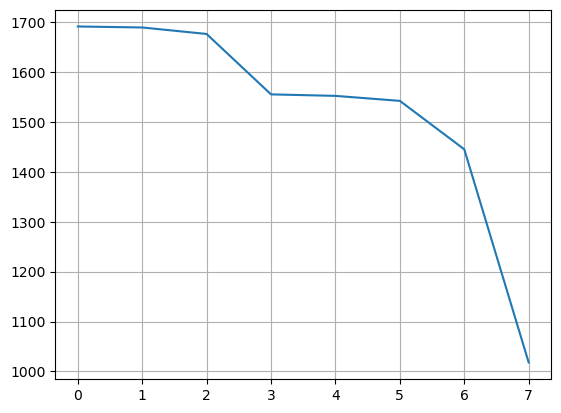

In [224]:
pl = sns.lineplot(sorted(anno_counts, reverse=True))
pl.grid()

In [225]:
subset_list = [8,7,6,5,4,3,2,1]

In [226]:
# new algorithm, just num authors

path_to_save = path_to_data

df_copy = data.copy()

for num_annos in subset_list:
    print('#'*50)
    df_copy = reduce_to_num_annos_by_remove_min(df_copy, num_annos)
    
    print(df_copy.shape)
    
    df_copy.to_csv(f'{path_to_data}/{ds_name}_{num_annos}_annos_filtered.csv')

##################################################
(4050, 11)
##################################################
(4050, 10)
##################################################
(4027, 9)
##################################################
(3951, 8)
##################################################
(3765, 7)
##################################################
(3414, 6)
##################################################
(2736, 5)
##################################################
(1691, 4)


# HSBrexit

In [49]:
path_to_data = '../data/HSBrexit_data/'
ds_name = 'HSBrexit'

## preprocess and transpose

In [66]:
all_df = pd.DataFrame(columns=['text','id'])

for split in ['train','dev','test']:
    with open(f'{path_to_data}{ds_name}_{split}.json') as file:
        d = json.load(file)
        
    for sub_d in d.values():
        idx = len(all_df)
        text = sub_d['text']
        
        assert(text not in all_df['text'])
        
        all_df.loc[idx,'id'] = int(idx)
        all_df.loc[idx,'text'] = text
        
        annotators = sub_d['annotators'].split(',')
        labels = [int(l) for l in sub_d['annotations'].split(',')]
        for annotator, label in zip(annotators, labels):
            all_df.loc[idx, annotator] = label

all_df.id = all_df.id.convert_dtypes()

[1, 0, 1, 0, 0, 1]
[0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 1, 0]
[0, 1, 0, 1, 1, 1]
[0, 0, 0, 0, 1, 1]
[0, 0, 0, 0, 1, 0]
[0, 0, 0, 1, 1, 0]
[0, 0, 0, 0, 1, 0]
[0, 0, 0, 1, 1, 0]
[1, 0, 0, 1, 1, 1]
[0, 0, 0, 1, 0, 1]
[1, 0, 0, 1, 1, 1]
[0, 1, 0, 0, 0, 0]
[0, 0, 0, 1, 1, 1]
[0, 0, 0, 1, 0, 0]
[0, 0, 0, 1, 1, 0]
[0, 0, 0, 0, 1, 0]
[0, 0, 0, 1, 1, 0]
[1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 1]
[1, 1, 0, 1, 1, 1]
[1, 0, 1, 1, 1, 1]
[0, 0, 0, 1, 1, 1]
[0, 0, 0, 0, 1, 1]
[0, 0, 0, 0, 1, 0]
[1, 1, 0, 0, 1, 0]
[0, 0, 0, 0, 1, 0]
[0, 0, 1, 1, 1, 1]
[0, 0, 0, 0, 1, 1]
[0, 0, 0, 1, 0, 1]
[0, 0, 0, 1, 1, 1]
[0, 0, 1, 1, 0, 0]
[0, 0, 0, 1, 1, 0]
[0, 0, 0, 1, 1, 1]
[0, 0, 0, 1, 1, 0]
[0, 0, 0, 1, 1, 0]
[0, 1, 0, 1, 1, 1]
[0, 0, 0, 1, 1, 1]
[0, 1, 0, 0, 1, 0]
[0, 0, 0, 0, 1, 0]
[1, 0, 0, 0, 1, 1]
[0, 0, 0, 1, 1, 0]
[0, 1, 0, 0, 1, 1]
[0, 0, 0, 1, 1, 0]
[0, 0, 1, 1, 1, 1]
[0, 0, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 1]
[0, 0, 0, 1, 0, 0]
[0, 1, 1, 1, 1, 1]
[0, 0, 0, 1, 1, 0]
[1, 0, 0, 1, 1, 1]
[0, 0, 0, 1, 0, 1]
[0, 0, 0, 0,

In [67]:
all_df

,text,id,Ann1,Ann2,Ann3,Ann4,Ann5,Ann6
0,<user> <user> I'm so glad about #Brexit.. My a...,0,0.0,0.0,0.0,0.0,0.0,0.0
1,RT <user>: There was more to #Brexit than immi...,1,0.0,0.0,0.0,0.0,0.0,0.0
2,"At the end of the day, the leave campaign won ...",2,0.0,0.0,0.0,0.0,0.0,0.0
3,So the reducing migration thing wasn't quite w...,3,0.0,0.0,0.0,0.0,0.0,0.0
4,A Brit Immigrant Asks Britain to Become India’...,4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1115,<user> Hmm... for #Brexit they can't really ch...,1115,0.0,0.0,0.0,0.0,0.0,0.0
1116,"Sadiq, Isis Muslim mayor is a total lunatic an...",1116,0.0,0.0,0.0,1.0,1.0,1.0
1117,Fusilier Lee Rigby&lt;----Not Forgotten During...,1117,0.0,0.0,0.0,1.0,1.0,1.0
1118,Because the world Knows #Trump is the only one...,1118,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
anno_to_id_mapping = {anno: anno.strip('Ann') for anno in [x for x in all_df.columns if 'Ann' in x]}
with open(f'{path_to_data}{ds_name}_anno_to_id_mapping.json','w') as f:
    json.dump(anno_to_id_mapping, f)

In [69]:
all_df = all_df.rename(anno_to_id_mapping, axis=1)

In [70]:
annos = get_annos(all_df)

In [71]:
all_df['majority'] = (all_df[annos].sum(axis=1) / all_df[annos].count(axis=1) > 0.5).astype('int')

In [72]:
all_df

,text,id,1,2,3,4,5,6,majority
0,<user> <user> I'm so glad about #Brexit.. My a...,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,RT <user>: There was more to #Brexit than immi...,1,0.0,0.0,0.0,0.0,0.0,0.0,0
2,"At the end of the day, the leave campaign won ...",2,0.0,0.0,0.0,0.0,0.0,0.0,0
3,So the reducing migration thing wasn't quite w...,3,0.0,0.0,0.0,0.0,0.0,0.0,0
4,A Brit Immigrant Asks Britain to Become India’...,4,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
1115,<user> Hmm... for #Brexit they can't really ch...,1115,0.0,0.0,0.0,0.0,0.0,0.0,0
1116,"Sadiq, Isis Muslim mayor is a total lunatic an...",1116,0.0,0.0,0.0,1.0,1.0,1.0,0
1117,Fusilier Lee Rigby&lt;----Not Forgotten During...,1117,0.0,0.0,0.0,1.0,1.0,1.0,0
1118,Because the world Knows #Trump is the only one...,1118,0.0,0.0,0.0,0.0,0.0,0.0,0


In [73]:
print(all_df['majority'].value_counts())

majority
0    1055
1      65
Name: count, dtype: int64


In [74]:
all_df.to_csv(f'{path_to_data}{ds_name}_all_transposed.csv', index=False)

## split

In [75]:
data = pd.read_csv(f'{path_to_data}{ds_name}_all_transposed.csv')

In [76]:
data

,text,id,1,2,3,4,5,6,majority
0,<user> <user> I'm so glad about #Brexit.. My a...,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,RT <user>: There was more to #Brexit than immi...,1,0.0,0.0,0.0,0.0,0.0,0.0,0
2,"At the end of the day, the leave campaign won ...",2,0.0,0.0,0.0,0.0,0.0,0.0,0
3,So the reducing migration thing wasn't quite w...,3,0.0,0.0,0.0,0.0,0.0,0.0,0
4,A Brit Immigrant Asks Britain to Become India’...,4,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
1115,<user> Hmm... for #Brexit they can't really ch...,1115,0.0,0.0,0.0,0.0,0.0,0.0,0
1116,"Sadiq, Isis Muslim mayor is a total lunatic an...",1116,0.0,0.0,0.0,1.0,1.0,1.0,0
1117,Fusilier Lee Rigby&lt;----Not Forgotten During...,1117,0.0,0.0,0.0,1.0,1.0,1.0,0
1118,Because the world Knows #Trump is the only one...,1118,0.0,0.0,0.0,0.0,0.0,0.0,0


In [77]:
data[annos].value_counts()

1    2    3    4    5    6  
0.0  0.0  0.0  0.0  0.0  0.0    762
               1.0  1.0  1.0     62
                         0.0     56
               0.0  1.0  0.0     51
                    0.0  1.0     24
               1.0  0.0  0.0     20
               0.0  1.0  1.0     18
1.0  1.0  1.0  1.0  1.0  1.0     13
0.0  0.0  0.0  1.0  0.0  1.0     12
          1.0  1.0  1.0  1.0     10
1.0  0.0  1.0  1.0  1.0  1.0      9
          0.0  1.0  1.0  1.0      8
0.0  1.0  0.0  1.0  1.0  1.0      7
     0.0  1.0  0.0  0.0  0.0      6
               1.0  1.0  0.0      5
     1.0  1.0  1.0  1.0  1.0      5
     0.0  1.0  0.0  1.0  0.0      4
     1.0  0.0  0.0  1.0  0.0      4
                    0.0  0.0      4
          1.0  1.0  1.0  0.0      3
1.0  0.0  0.0  0.0  1.0  1.0      3
     1.0  1.0  1.0  1.0  0.0      3
0.0  1.0  0.0  1.0  0.0  1.0      3
1.0  1.0  1.0  0.0  0.0  1.0      2
     0.0  0.0  1.0  0.0  0.0      2
     1.0  0.0  1.0  1.0  1.0      2
0.0  0.0  1.0  1.0  0.0  0.0      2

In [78]:
rand_state = SEEDS[0]
df = data

k_fold_train_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_state)
train_split_ids, test_split_ids = next(iter(k_fold_train_test.split(X=df, y=df.majority)))

tr_df_maj = df.iloc[train_split_ids.tolist()]
test_df_maj = df.iloc[test_split_ids.tolist()]

k_fold_test_val = StratifiedKFold(n_splits=4, shuffle=True, random_state=rand_state)
train_split_ids_new, val_split_ids_new = next(iter(k_fold_test_val.split(X=tr_df_maj, y=tr_df_maj.majority)))

val_split_ids = train_split_ids[val_split_ids_new]
train_split_ids = train_split_ids[train_split_ids_new]

tr_df_maj = df.iloc[train_split_ids.tolist()]
val_df_maj = df.iloc[val_split_ids.tolist()]

# tr_df_maj = tr_df_maj[['id']]
# val_df_maj = val_df_maj[['id']]
# test_df_maj = test_df_maj[['id']]

tr_df_maj.to_csv(f'{path_to_data}train_{ds_name.lower()}.csv', index=False)
val_df_maj.to_csv(f'{path_to_data}val_{ds_name.lower()}.csv', index=False)
test_df_maj.to_csv(f'{path_to_data}test_{ds_name.lower()}.csv', index=False)

## create subsets

In [79]:
anno_counts = data[annos].count(axis=0)

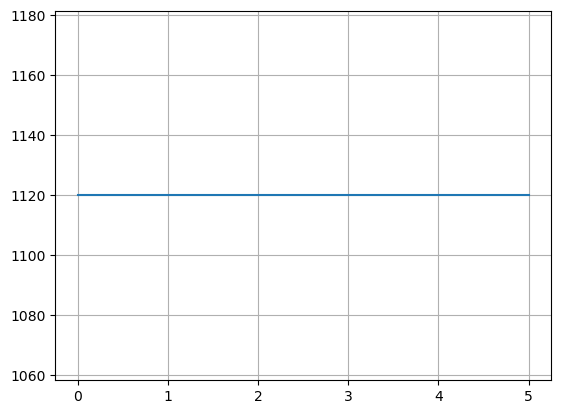

In [80]:
pl = sns.lineplot(sorted(anno_counts, reverse=True))
pl.grid()

In [81]:
subset_list = [6,5,4,3,2,1]

In [82]:
# new algorithm, just num authors

path_to_save = path_to_data

df_copy = data.copy()

for num_annos in subset_list:
    print('#'*50)
    df_copy = reduce_to_num_annos_by_remove_min(df_copy, num_annos)
    
    print(df_copy.shape)
    
    df_copy.to_csv(f'{path_to_data}/{ds_name}_{num_annos}_annos_filtered.csv')

##################################################
(1120, 9)
##################################################
(1120, 8)
##################################################
(1120, 7)
##################################################
(1120, 6)
##################################################
(1120, 5)
##################################################
(1120, 4)


In [83]:
[float(f"{x}e-{y}") for x,y in zip([1,5]*4,[3,3,4,4,5,5,6,6])]

[0.001, 0.005, 0.0001, 0.0005, 1e-05, 5e-05, 1e-06, 5e-06]

# Multi Domain Dataset

In [104]:
path_to_data = '../data/MD_data/'
ds_name = 'MD'

## preprocess and transpose

In [106]:
dfs = []

offset = 0

for split in ['train','dev','test']:
    with open(f'{path_to_data}{ds_name}_{split}.json') as file:
        d = json.load(file)
        
    texts = []
    ids = []
    
    anno_strings = [val['annotators'] for val in d.values()]
    anno_strings = [a for annos in anno_strings for a in annos.split(',')]
    annos = list(set(anno_strings))
    
    annos_vals_dict = {anno:[] for anno in annos}
    
    for sub_d in d.values():
        idx = len(ids) + offset
        text = sub_d['text']
        
        assert(text not in texts)
        
        texts.append(text)
        ids.append(idx)
        
        # all_df.loc[idx,'id'] = int(idx)
        # all_df.loc[idx,'text'] = text
        
        annotators = sub_d['annotators'].split(',')
        labels = [int(l) for l in sub_d['annotations'].split(',')]
        
        anno_labels = dict(zip(annotators, labels))
        
        for k, v in annos_vals_dict.items():
            if k in annotators:
                v.append(anno_labels[k])
            else:
                v.append(float('NaN'))
        
        # for annotator, label in zip(annotators, labels):
        #     all_df.loc[idx, annotator] = label

    data_dict = {'text':texts, 'id':ids}
    data_dict.update(annos_vals_dict)
    df = pd.DataFrame(data_dict)
    dfs.append(df)
    
    offset += len(ids)
    
all_df = pd.concat(dfs)
all_df.id = all_df.id.convert_dtypes()

In [107]:
all_df = all_df.loc[:, (all_df.count() >= 5)]

In [108]:
all_df

,text,id,Ann91,Ann3,Ann247,Ann298,Ann109,Ann698,Ann471,Ann129,...,Ann470,Ann614,Ann174,Ann683,Ann333,Ann207,Ann363,Ann450,Ann813,Ann132
0,<user> <user> No way Jose!!,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Good god, what is the matter with people ?",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,<user> <user> <user> <user> Um the Kurds are h...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,What is WRONG with these people?,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,<user> This earpiece too plus a wire on his sl...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3052,<user> you’re a bold faced liar. You will be u...,10748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3053,<user> <user> <user> hey NJ even <user> can vo...,10749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3054,And people ask me and my peers why we hate our...,10750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3055,<user> if you love us BLACK People so much th...,10751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
anno_to_id_mapping = {anno: anno.strip('Ann') for anno in [x for x in all_df.columns if 'Ann' in x]}
with open(f'{path_to_data}{ds_name}_anno_to_id_mapping.json','w') as f:
    json.dump(anno_to_id_mapping, f)

In [110]:
all_df = all_df.rename(anno_to_id_mapping, axis=1)

In [111]:
annos = get_annos(all_df)

In [112]:
all_df['majority'] = (all_df[annos].sum(axis=1) / all_df[annos].count(axis=1) > 0.5).astype('int')

In [113]:
all_df.to_csv(f'{path_to_data}{ds_name}_all_transposed.csv', index=False)

In [115]:
all_df.majority.value_counts()

majority
0    7393
1    3360
Name: count, dtype: int64

## split

In [116]:
data = pd.read_csv(f'{path_to_data}{ds_name}_all_transposed.csv')

In [117]:
data[annos].count()

91      17
3       18
247     76
298     51
109      9
      ... 
207     22
363      9
450      9
813     85
132    125
Length: 751, dtype: int64

In [118]:
rand_state = SEEDS[0]
df = data

k_fold_train_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_state)
train_split_ids, test_split_ids = next(iter(k_fold_train_test.split(X=df, y=df.majority)))

tr_df_maj = df.iloc[train_split_ids.tolist()]
test_df_maj = df.iloc[test_split_ids.tolist()]

k_fold_test_val = StratifiedKFold(n_splits=4, shuffle=True, random_state=rand_state)
train_split_ids_new, val_split_ids_new = next(iter(k_fold_test_val.split(X=tr_df_maj, y=tr_df_maj.majority)))

val_split_ids = train_split_ids[val_split_ids_new]
train_split_ids = train_split_ids[train_split_ids_new]

tr_df_maj = df.iloc[train_split_ids.tolist()]
val_df_maj = df.iloc[val_split_ids.tolist()]

# tr_df_maj = tr_df_maj[['id']]
# val_df_maj = val_df_maj[['id']]
# test_df_maj = test_df_maj[['id']]

tr_df_maj.to_csv(f'{path_to_data}train_{ds_name.lower()}.csv', index=False)
val_df_maj.to_csv(f'{path_to_data}val_{ds_name.lower()}.csv', index=False)
test_df_maj.to_csv(f'{path_to_data}test_{ds_name.lower()}.csv', index=False)

## create subsets

In [119]:
anno_counts = data[annos].count(axis=0)

In [120]:
anno_counts

91      17
3       18
247     76
298     51
109      9
      ... 
207     22
363      9
450      9
813     85
132    125
Length: 751, dtype: int64

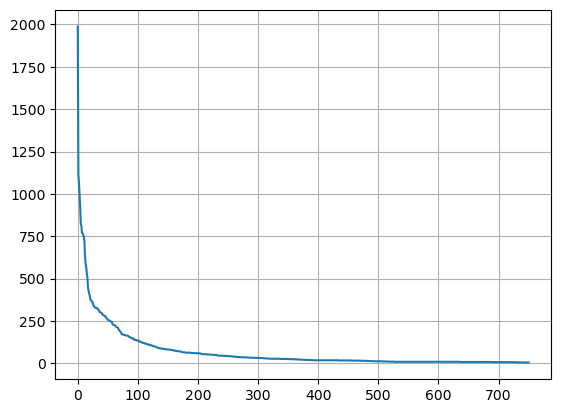

In [121]:
pl = sns.lineplot(sorted(anno_counts, reverse=True))
pl.grid()

In [122]:
subset_list =[751] + list(reversed(range(100,701,100))) + list(reversed(range(22,83,4))) + list(reversed(range(6,19,2))) +  [5,4,3,2,1]
print(subset_list)

[751, 700, 600, 500, 400, 300, 200, 100, 82, 78, 74, 70, 66, 62, 58, 54, 50, 46, 42, 38, 34, 30, 26, 22, 18, 16, 14, 12, 10, 8, 6, 5, 4, 3, 2, 1]


In [123]:
# new algorithm, just num authors

path_to_save = path_to_data

df_copy = data.copy()

for num_annos in subset_list:
    print('#'*50)
    df_copy = reduce_to_num_annos_by_remove_min(df_copy, num_annos)
    
    print(df_copy.shape)
    
    df_copy.to_csv(f'{path_to_data}/{ds_name}_{num_annos}_annos_filtered.csv')

##################################################
(10753, 754)
##################################################
(10753, 703)
##################################################
(10753, 603)
##################################################
(10753, 503)
##################################################
(10753, 403)
##################################################
(10753, 303)
##################################################
(10746, 203)
##################################################
(10657, 103)
##################################################
(10618, 85)
##################################################
(10578, 81)
##################################################
(10550, 77)
##################################################
(10538, 73)
##################################################
(10519, 69)
##################################################
(10469, 65)
##################################################
(10431, 61)
###############################################

## deal with errors

In [149]:
dataframe = mdd.copy()
dataframe = dataframe.replace(float('nan'), -1)
dataframe = filter_df_min_annotation_and_update_majority(dataframe, 1)

annotator_ids = [
    x for x in dataframe.columns if re.fullmatch(r'[0-9]+', x)]

dataframe = dataframe.convert_dtypes()
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-cased")

dataset = MultiTaskDataset(dataframe, tokenizer=tokenizer, max_length=64)

In [178]:
mdd.text[5196]

'Working after Covid19.  Lunch break.  #COVID19 #Covid_19 #CoronavirusUSA #EssentialWorker #EssentialWorkers #Essential'

In [179]:
train_all_ds = pd.read_csv(f'../data/MD_data/train_md.csv')
val_all_ds = pd.read_csv(f'../data/MD_data/val_md.csv')
test_all_ds = pd.read_csv(f'../data/MD_data/test_md.csv')

In [193]:
len(train_all_ds.id.unique()) == len(train_all_ds)

True

In [194]:
[x for x in train_all_ds.id if x in test_all_ds.id]

[1,
 5,
 6,
 7,
 26,
 27,
 31,
 35,
 37,
 40,
 44,
 45,
 48,
 59,
 62,
 75,
 78,
 81,
 90,
 91,
 93,
 108,
 109,
 119,
 124,
 126,
 136,
 137,
 144,
 150,
 153,
 158,
 163,
 169,
 182,
 186,
 188,
 189,
 196,
 197,
 204,
 207,
 210,
 211,
 214,
 219,
 220,
 224,
 225,
 226,
 227,
 243,
 250,
 252,
 258,
 265,
 267,
 270,
 271,
 283,
 297,
 298,
 306,
 307,
 325,
 330,
 343,
 347,
 350,
 365,
 370,
 374,
 382,
 384,
 392,
 396,
 404,
 413,
 415,
 417,
 420,
 423,
 429,
 432,
 437,
 446,
 453,
 454,
 455,
 456,
 457,
 458,
 471,
 473,
 475,
 478,
 479,
 480,
 483,
 497,
 498,
 500,
 510,
 518,
 519,
 529,
 530,
 531,
 536,
 540,
 542,
 545,
 546,
 547,
 557,
 559,
 561,
 570,
 574,
 576,
 577,
 580,
 581,
 588,
 608,
 615,
 617,
 633,
 639,
 640,
 641,
 650,
 651,
 652,
 655,
 678,
 690,
 693,
 694,
 701,
 704,
 708,
 710,
 713,
 716,
 719,
 727,
 729,
 737,
 745,
 747,
 751,
 753,
 754,
 756,
 771,
 791,
 796,
 805,
 807,
 812,
 815,
 824,
 827,
 828,
 841,
 850,
 856,
 857,
 858,
 864,

In [180]:
train_ds = dataframe[dataframe.id.isin(train_all_ds.id)]
val_ds = dataframe[dataframe.id.isin(val_all_ds.id)]
test_ds = dataframe[dataframe.id.isin(test_all_ds.id)]

In [181]:
dataframe = pd.concat([train_ds, val_ds, test_ds])

In [186]:
dataframe.loc[2]

KeyError: 2

In [168]:
train_ids = list(train_all_ds.id)

In [174]:
dataset.__getitem__(5196)

{'ids': tensor([  101,  9612,  1170,  3291, 18312, 16382,   119, 14557, 11273,  2549,
           119,   108, 18732, 23314,  2137, 16382,   108,  3291, 18312,   168,
          1627,   108,  3291, 15789, 27608, 13329,  1592,   108, 26768,  2924,
          1766,  4188,   108, 26768,  2924,  1766,  8811,   108, 26768,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]),
 'masks': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': 

In [170]:
train_sampler = SubsetRandomSampler(train_ids)

In [171]:
dataloader = DataLoader(
        dataset, batch_size=16, sampler=train_sampler)

In [172]:
for i, data_dict in enumerate(dataloader):
    print(data_dict)

/home/neuendo4/anaconda3/envs/master/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'ids': tensor([[  101, 11750,  1109,  ...,     0,     0,     0],
        [  101,  7911,  1500,  ...,     0,     0,     0],
        [  101,  1636,  1234,  ...,     0,     0,     0],
        ...,
        [  101,  1409,  1152,  ...,     0,     0,     0],
        [  101, 19253,  3568,  ...,     0,     0,     0],
        [  101,  1109,  2558,  ...,  1111,  7490,   102]]), 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'labels': tensor([[-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1],
        ...,
        [-1, -1, -1, 

In [ ]:
offset = 0
for split in ['train', 'val', 'test']:
    mdd = pd.read_csv(f'../data/from_funke/MultiDomain/MD-Agreement_{split}.csv')
    mdd = mdd.rename({'ANNOTATOR ID': 'anno_id', 'TEXT':'text', 'ANNOTATION':'label'}, axis=1)
    texts_unique = list(mdd.text.unique())
    mdd['post_id'] = mdd.text.map(lambda x: texts_unique.index(x) + offset)
    
    offset += len(texts_unique)
    
    mdd.to_csv(f'../data/from_funke/MultiDomain/MD_{split}.csv', index=False)

In [14]:
hs_train = pd.read_csv(f'../data/from_funke/HSBrexit/HS-Brexit_train.csv')
hs_val = pd.read_csv(f'../data/from_funke/HSBrexit/HS-Brexit_val.csv')
hs_test = pd.read_csv(f'../data/from_funke/HSBrexit/HS-Brexit_test.csv')

In [16]:
hs_all = pd.concat([hs_train, hs_val])

In [ ]:
md_all

,text,anno_id,label,post_id
0,No way Jose!!,Ann418,0,0
1,No way Jose!!,Ann266,0,0
2,No way Jose!!,Ann149,0,0
3,No way Jose!!,Ann730,0,0
4,No way Jose!!,Ann345,0,0
...,...,...,...,...
5515,Cnn what clowns you all are such tool bags,Ann260,1,7695
5516,Cnn what clowns you all are such tool bags,Ann140,1,7695
5517,Cnn what clowns you all are such tool bags,Ann205,1,7695
5518,Cnn what clowns you all are such tool bags,Ann779,1,7695


In [ ]:
mdd_anno_to_id_mapping = {anno: anno.strip('Ann') for anno in md_all.anno_id}
with open('../data/from_funke/MultiDomain/MD_anno_to_id_mapping.json','w') as f:
    json.dump(mdd_anno_to_id_mapping, f)

In [ ]:
md_all.anno_id = md_all.anno_id.apply(lambda x: x.strip('Ann'))

In [ ]:
md_text_unique = list(md_all.text.unique())

In [ ]:
md_all['post_id'] = md_all.text.map(lambda x: md_text_unique.index(x))

In [ ]:
md_all = md_all.rename({'post_id':'id'}, axis=1)

In [ ]:
md_all.to_csv(f'../data/from_funke/MultiDomain/MD_all.csv')

In [ ]:
mdd_transposed = md_all.pivot_table(index='id',columns='anno_id', values='label')
mdd_transposed = mdd_transposed.reset_index()
mdd_transposed.columns.name=None

In [ ]:
mdd_transposed['text'] = mdd_transposed.id.map(lambda x: md_text_unique[x])

In [ ]:
mdd_annos = get_annos(mdd_transposed)

In [ ]:
mdd_transposed['majority'] = (mdd_transposed[mdd_annos].sum(axis=1) / mdd_transposed[mdd_annos].count(axis=1) > 0.5).astype('int')

In [ ]:
mdd_transposed

,id,0,1,10,100,101,102,103,104,105,...,90,91,93,94,95,96,97,99,text,majority
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No way Jose!!,0
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Good god, what is the matter with people ?",0
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Um the Kurds are helping the ppl Of the Ukrain...,0
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,What is WRONG with these people?,0
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,This earpiece too plus a wire on his sleeves! ...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7689,7689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Can’t let the scumbags on Wall Street try any ...,0
7690,7690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,you are full of BS. #munchinLies,1
7691,7691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Oral sex, too. Pat, how come you didn't have a...",1
7692,7692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,He’s the only President in history to declare ...,0


In [ ]:
mdd_transposed.to_csv('../data/from_funke/MultiDomain/MD_all_transposed.csv', index=False)

In [ ]:
mdd = pd.read_csv('../data/from_funke/MultiDomain/MD_all_transposed.csv')

In [ ]:
rand_state = SEEDS[0]
df = mdd
name = 'MD'

k_fold_train_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_state)
train_split_ids, test_split_ids = next(iter(k_fold_train_test.split(X=df, y=df.majority)))

tr_df_maj = df.iloc[train_split_ids.tolist()]
test_df_maj = df.iloc[test_split_ids.tolist()]

k_fold_test_val = StratifiedKFold(n_splits=4, shuffle=True, random_state=rand_state)
train_split_ids_new, val_split_ids_new = next(iter(k_fold_test_val.split(X=tr_df_maj, y=tr_df_maj.majority)))

val_split_ids = train_split_ids[val_split_ids_new]
train_split_ids = train_split_ids[train_split_ids_new]

tr_df_maj = df.iloc[train_split_ids.tolist()]
val_df_maj = df.iloc[val_split_ids.tolist()]

# tr_df_maj = tr_df_maj[['id']]
# val_df_maj = val_df_maj[['id']]
# test_df_maj = test_df_maj[['id']]

tr_df_maj.to_csv(f'../data/{name.upper()}_data/train_{name.lower()}.csv', index=False)
val_df_maj.to_csv(f'../data/{name.upper()}_data/val_{name.lower()}.csv', index=False)
test_df_maj.to_csv(f'../data/{name.upper()}_data/test_{name.lower()}.csv', index=False)

In [ ]:
mdd_annos = get_annos(mdd)

In [ ]:
mdd_anno_counts = mdd[mdd_annos].count(axis=0)

In [ ]:
# sorted(mdd_anno_counts, reverse=True)[:50]

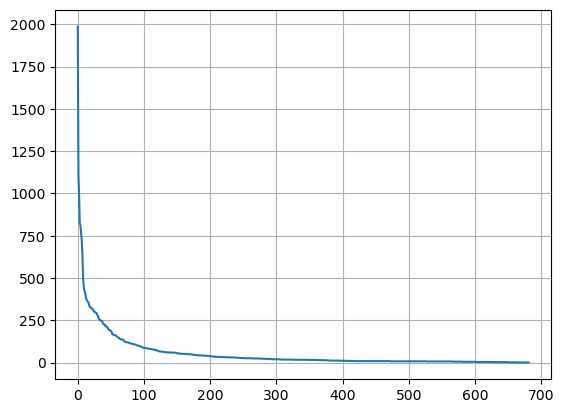

In [ ]:
pl = sns.lineplot(sorted(mdd_anno_counts, reverse=True))
pl.grid()

In [ ]:
len(mdd_annos)

682

In [ ]:
subset_list = sorted(list(range(6,19,2)) + list(range(22,83,4)) + list(range(100,601,100)) + [682], reverse=True)
subset_list = sorted(list(range(6,19,2)), reverse=True)

In [ ]:
GHC_df = pd.read_csv('../data/GHC_data/train_ghc.csv')

In [ ]:
# new algorithm, just num authors

path_to_save = f"../data/MD_data/"

# mdd_copy = mdd.copy()
mdd_copy = pd.read_csv('../data/MD_data/MD_22_annos_filtered.csv')

for num_annos in subset_list:
    print('#'*50)
    mdd_copy = reduce_to_num_annos_by_remove_min(mdd_copy, num_annos)
    
    print(mdd_copy.shape)
    
    mdd_copy.to_csv(f'../data/MD_data/MD_{num_annos}_annos_filtered.csv')

##################################################
(6229, 22)
##################################################
(6123, 20)
##################################################
(5972, 18)
##################################################
(5865, 16)
##################################################
(5716, 14)
##################################################
(5352, 12)
##################################################
(4937, 10)


In [ ]:
[float(f"{x}e-{y}") for x,y in zip([1,5]*4,[3,3,4,4,5,5,6,6])]

[0.001, 0.005, 0.0001, 0.0005, 1e-05, 5e-05, 1e-06, 5e-06]

In [ ]:
'../results/MD_multi-tasking_lr_search/MD-multi-tasking_lr/'.strip('/').split('/')

['..', 'results', 'MD_multi-tasking_lr_search', 'MD-multi-tasking_lr']

In [ ]:
os.path.join(['a','b'])

TypeError: expected str, bytes or os.PathLike object, not list

In [ ]:
dataframe = mdd.copy()
dataframe = dataframe.replace(float('nan'), -1)
dataframe = filter_df_min_annotation_and_update_majority(dataframe, 1)

annotator_ids = [
    x for x in dataframe.columns if re.fullmatch(r'[0-9]+', x)]

dataframe = dataframe.convert_dtypes()
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-cased")

dataset = MultiTaskDataset(dataframe, tokenizer=tokenizer, max_length=64)

In [ ]:
mdd.text[5196]

'Working after Covid19.  Lunch break.  #COVID19 #Covid_19 #CoronavirusUSA #EssentialWorker #EssentialWorkers #Essential'

In [ ]:
train_all_ds = pd.read_csv(f'../data/MD_data/train_md.csv')
val_all_ds = pd.read_csv(f'../data/MD_data/val_md.csv')
test_all_ds = pd.read_csv(f'../data/MD_data/test_md.csv')

In [ ]:
len(train_all_ds.id.unique()) == len(train_all_ds)

True

In [ ]:
[x for x in train_all_ds.id if x in test_all_ds.id]

[1,
 5,
 6,
 7,
 26,
 27,
 31,
 35,
 37,
 40,
 44,
 45,
 48,
 59,
 62,
 75,
 78,
 81,
 90,
 91,
 93,
 108,
 109,
 119,
 124,
 126,
 136,
 137,
 144,
 150,
 153,
 158,
 163,
 169,
 182,
 186,
 188,
 189,
 196,
 197,
 204,
 207,
 210,
 211,
 214,
 219,
 220,
 224,
 225,
 226,
 227,
 243,
 250,
 252,
 258,
 265,
 267,
 270,
 271,
 283,
 297,
 298,
 306,
 307,
 325,
 330,
 343,
 347,
 350,
 365,
 370,
 374,
 382,
 384,
 392,
 396,
 404,
 413,
 415,
 417,
 420,
 423,
 429,
 432,
 437,
 446,
 453,
 454,
 455,
 456,
 457,
 458,
 471,
 473,
 475,
 478,
 479,
 480,
 483,
 497,
 498,
 500,
 510,
 518,
 519,
 529,
 530,
 531,
 536,
 540,
 542,
 545,
 546,
 547,
 557,
 559,
 561,
 570,
 574,
 576,
 577,
 580,
 581,
 588,
 608,
 615,
 617,
 633,
 639,
 640,
 641,
 650,
 651,
 652,
 655,
 678,
 690,
 693,
 694,
 701,
 704,
 708,
 710,
 713,
 716,
 719,
 727,
 729,
 737,
 745,
 747,
 751,
 753,
 754,
 756,
 771,
 791,
 796,
 805,
 807,
 812,
 815,
 824,
 827,
 828,
 841,
 850,
 856,
 857,
 858,
 864,

In [ ]:
train_ds = dataframe[dataframe.id.isin(train_all_ds.id)]
val_ds = dataframe[dataframe.id.isin(val_all_ds.id)]
test_ds = dataframe[dataframe.id.isin(test_all_ds.id)]

In [ ]:
dataframe = pd.concat([train_ds, val_ds, test_ds])

In [ ]:
dataframe.loc[2]

KeyError: 2

In [ ]:
train_ids = list(train_all_ds.id)

In [ ]:
dataset.__getitem__(5196)

{'ids': tensor([  101,  9612,  1170,  3291, 18312, 16382,   119, 14557, 11273,  2549,
           119,   108, 18732, 23314,  2137, 16382,   108,  3291, 18312,   168,
          1627,   108,  3291, 15789, 27608, 13329,  1592,   108, 26768,  2924,
          1766,  4188,   108, 26768,  2924,  1766,  8811,   108, 26768,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]),
 'masks': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': 

In [ ]:
train_sampler = SubsetRandomSampler(train_ids)

In [ ]:
dataloader = DataLoader(
        dataset, batch_size=16, sampler=train_sampler)

In [ ]:
for i, data_dict in enumerate(dataloader):
    print(data_dict)

/home/neuendo4/anaconda3/envs/master/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'ids': tensor([[  101, 11750,  1109,  ...,     0,     0,     0],
        [  101,  7911,  1500,  ...,     0,     0,     0],
        [  101,  1636,  1234,  ...,     0,     0,     0],
        ...,
        [  101,  1409,  1152,  ...,     0,     0,     0],
        [  101, 19253,  3568,  ...,     0,     0,     0],
        [  101,  1109,  2558,  ...,  1111,  7490,   102]]), 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'labels': tensor([[-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1],
        ...,
        [-1, -1, -1, 

In [ ]:
offset = 0
for split in ['train', 'val', 'test']:
    mdd = pd.read_csv(f'../data/from_funke/MultiDomain/MD-Agreement_{split}.csv')
    mdd = mdd.rename({'ANNOTATOR ID': 'anno_id', 'TEXT':'text', 'ANNOTATION':'label'}, axis=1)
    texts_unique = list(mdd.text.unique())
    mdd['post_id'] = mdd.text.map(lambda x: texts_unique.index(x) + offset)
    
    offset += len(texts_unique)
    
    mdd.to_csv(f'../data/from_funke/MultiDomain/MD_{split}.csv', index=False)

In [8]:
ca_train = pd.read_csv(f'../data/from_funke/Conversational_abuse/ConvAbuse_train.csv')
ca_val = pd.read_csv(f'../data/from_funke/Conversational_abuse/ConvAbuse_val.csv')
ca_test = pd.read_csv(f'../data/from_funke/Conversational_abuse/ConvAbuse_test.csv')
# md_test = pd.read_csv(f'../data/from_funke/MultiDomain/MD_test.csv')

In [12]:
ca_train[ca_train.ANNOTATION==1]

,PREV_AGENT,PREV_USER,CURRENT_AGENT,CURRENT_USER,ANNOTATOR ID,ABUSE_SEVERITY,ANNOTATION
6,You are being a bit negative.,I hate you,Do you wish to hate me?,yea,Ann1,-1,1
17,Do any other reasons not come to mind?,I want to cum,Why do you want to cum?,It feels good,Ann5,-1,1
43,Do you wish to want to fuck me?,yes with high heels too,You are sure?,yes I am hard,Ann4,-1,1
44,Do you wish to want to fuck me?,yes with high heels too,You are sure?,yes I am hard,Ann6,-1,1
45,Do you wish to want to fuck me?,yes with high heels too,You are sure?,yes I am hard,Ann8,-2,1
...,...,...,...,...,...,...,...
7132,What about your own a fuckin bitch?,what,Does that question interest you?,fuck no,Ann1,-1,1
7133,What about your own a fuckin bitch?,what,Does that question interest you?,fuck no,Ann6,-1,1
7135,Would you like it if they were not a bitch?,where is a demonstreantion of sperling's ewper...,Please go on.,fuck,Ann1,-1,1
7136,Would you like it if they were not a bitch?,where is a demonstreantion of sperling's ewper...,Please go on.,fuck,Ann2,-2,1


In [ ]:
md_all = pd.concat([md_train, md_val])

In [ ]:
md_all

,text,anno_id,label,post_id
0,No way Jose!!,Ann418,0,0
1,No way Jose!!,Ann266,0,0
2,No way Jose!!,Ann149,0,0
3,No way Jose!!,Ann730,0,0
4,No way Jose!!,Ann345,0,0
...,...,...,...,...
5515,Cnn what clowns you all are such tool bags,Ann260,1,7695
5516,Cnn what clowns you all are such tool bags,Ann140,1,7695
5517,Cnn what clowns you all are such tool bags,Ann205,1,7695
5518,Cnn what clowns you all are such tool bags,Ann779,1,7695


In [ ]:
mdd_anno_to_id_mapping = {anno: anno.strip('Ann') for anno in md_all.anno_id}
with open('../data/from_funke/MultiDomain/MD_anno_to_id_mapping.json','w') as f:
    json.dump(mdd_anno_to_id_mapping, f)

In [ ]:
md_all.anno_id = md_all.anno_id.apply(lambda x: x.strip('Ann'))

In [ ]:
md_text_unique = list(md_all.text.unique())

In [ ]:
md_all['post_id'] = md_all.text.map(lambda x: md_text_unique.index(x))

In [ ]:
md_all = md_all.rename({'post_id':'id'}, axis=1)

In [ ]:
md_all.to_csv(f'../data/from_funke/MultiDomain/MD_all.csv')

In [ ]:
mdd_transposed = md_all.pivot_table(index='id',columns='anno_id', values='label')
mdd_transposed = mdd_transposed.reset_index()
mdd_transposed.columns.name=None

In [ ]:
mdd_transposed['text'] = mdd_transposed.id.map(lambda x: md_text_unique[x])

In [ ]:
mdd_annos = get_annos(mdd_transposed)

In [ ]:
mdd_transposed['majority'] = (mdd_transposed[mdd_annos].sum(axis=1) / mdd_transposed[mdd_annos].count(axis=1) > 0.5).astype('int')

In [ ]:
mdd_transposed

,id,0,1,10,100,101,102,103,104,105,...,90,91,93,94,95,96,97,99,text,majority
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No way Jose!!,0
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Good god, what is the matter with people ?",0
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Um the Kurds are helping the ppl Of the Ukrain...,0
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,What is WRONG with these people?,0
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,This earpiece too plus a wire on his sleeves! ...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7689,7689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Can’t let the scumbags on Wall Street try any ...,0
7690,7690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,you are full of BS. #munchinLies,1
7691,7691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Oral sex, too. Pat, how come you didn't have a...",1
7692,7692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,He’s the only President in history to declare ...,0


In [ ]:
mdd_transposed.to_csv('../data/from_funke/MultiDomain/MD_all_transposed.csv', index=False)

In [ ]:
mdd = pd.read_csv('../data/from_funke/MultiDomain/MD_all_transposed.csv')

In [ ]:
rand_state = SEEDS[0]
df = mdd
name = 'MD'

k_fold_train_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_state)
train_split_ids, test_split_ids = next(iter(k_fold_train_test.split(X=df, y=df.majority)))

tr_df_maj = df.iloc[train_split_ids.tolist()]
test_df_maj = df.iloc[test_split_ids.tolist()]

k_fold_test_val = StratifiedKFold(n_splits=4, shuffle=True, random_state=rand_state)
train_split_ids_new, val_split_ids_new = next(iter(k_fold_test_val.split(X=tr_df_maj, y=tr_df_maj.majority)))

val_split_ids = train_split_ids[val_split_ids_new]
train_split_ids = train_split_ids[train_split_ids_new]

tr_df_maj = df.iloc[train_split_ids.tolist()]
val_df_maj = df.iloc[val_split_ids.tolist()]

# tr_df_maj = tr_df_maj[['id']]
# val_df_maj = val_df_maj[['id']]
# test_df_maj = test_df_maj[['id']]

tr_df_maj.to_csv(f'../data/{name.upper()}_data/train_{name.lower()}.csv', index=False)
val_df_maj.to_csv(f'../data/{name.upper()}_data/val_{name.lower()}.csv', index=False)
test_df_maj.to_csv(f'../data/{name.upper()}_data/test_{name.lower()}.csv', index=False)

In [ ]:
mdd_annos = get_annos(mdd)

In [ ]:
mdd_anno_counts = mdd[mdd_annos].count(axis=0)

In [ ]:
# sorted(mdd_anno_counts, reverse=True)[:50]

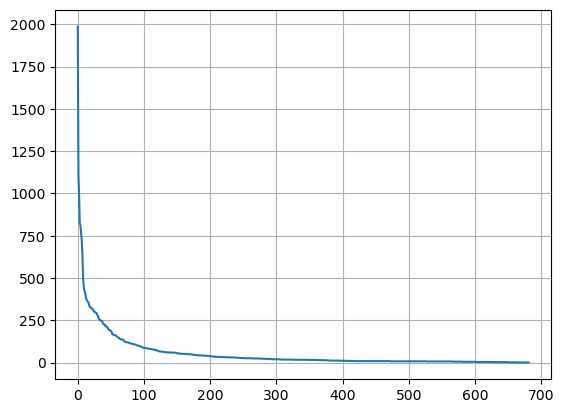

In [ ]:
pl = sns.lineplot(sorted(mdd_anno_counts, reverse=True))
pl.grid()

In [ ]:
len(mdd_annos)

682

In [ ]:
subset_list = sorted(list(range(6,19,2)) + list(range(22,83,4)) + list(range(100,601,100)) + [682], reverse=True)
subset_list = sorted(list(range(6,19,2)), reverse=True)

In [ ]:
GHC_df = pd.read_csv('../data/GHC_data/train_ghc.csv')

In [ ]:
# new algorithm, just num authors

path_to_save = f"../data/MD_data/"

# mdd_copy = mdd.copy()
mdd_copy = pd.read_csv('../data/MD_data/MD_22_annos_filtered.csv')

for num_annos in subset_list:
    print('#'*50)
    mdd_copy = reduce_to_num_annos_by_remove_min(mdd_copy, num_annos)
    
    print(mdd_copy.shape)
    
    mdd_copy.to_csv(f'../data/MD_data/MD_{num_annos}_annos_filtered.csv')

##################################################
(6229, 22)
##################################################
(6123, 20)
##################################################
(5972, 18)
##################################################
(5865, 16)
##################################################
(5716, 14)
##################################################
(5352, 12)
##################################################
(4937, 10)


In [ ]:
[float(f"{x}e-{y}") for x,y in zip([1,5]*4,[3,3,4,4,5,5,6,6])]

[0.001, 0.005, 0.0001, 0.0005, 1e-05, 5e-05, 1e-06, 5e-06]

In [ ]:
'../results/MD_multi-tasking_lr_search/MD-multi-tasking_lr/'.strip('/').split('/')

['..', 'results', 'MD_multi-tasking_lr_search', 'MD-multi-tasking_lr']

In [ ]:
os.path.join(['a','b'])

TypeError: expected str, bytes or os.PathLike object, not list

# load dataframes

In [ ]:
mdd_df = pd.read_csv('../data/from_funke/MultiDomain/MD_all_transposed.csv')

In [ ]:
# path_to_sc_filtered = '../../user_perception/data/sc_filtered_from_bela/'
# for df_name in sorted(os.listdir(path_to_sc_filtered)):
#     sc_df = pd.read_csv(path_to_sc_filtered+df_name)
#     sc_df = sc_df.merge(posts_df[['post_id','situation']], left_on='parent_id', right_on='post_id')
#     sc_df = sc_df.rename(columns={'situation':'text'})
#     sc_df.to_csv(path_to_sc_filtered+df_name)

In [ ]:
comments_df = pd.read_csv(path_to_data+'social_norms_clean.csv')
posts_df = pd.read_csv(path_to_data +'social_chemistry_clean_with_fulltexts_and_authors.csv', compression='gzip')

In [ ]:
# comments_df = comments_df[~comments_df.author_name.isnull()]
# comments_df = comments_df[comments_df.author_name!='Judgement_Bot_AITA']
# comments_df = comments_df[comments_df.author_name!='deleted']

# comments_df = comments_df[comments_df.parent_id.isin(posts_df.post_id)]
# posts_df = posts_df[posts_df.post_id.isin(comments_df.parent_id)]

# comments_df.to_csv(path_to_data+'social_norms_clean.csv')
# posts_df.to_csv(path_to_data +'social_chemistry_clean_with_fulltexts_and_authors.csv', compression='gzip')

In [ ]:
comments_df = comments_df[['id','parent_id','label','body','author_name']]

In [ ]:
# sc_df = comments_df.merge(posts_df[['post_id','situation']], left_on='parent_id',right_on='post_id')
# sc_df.rename(columns={'situation':'text'}, inplace=True)
# sc_df = filter_df_min_annotation_and_update_majority(sc_df,1)
# sc_df

# sc_df = pd.read_csv(path_to_data+'social_norms_pivoted_min_20_per_annotator.csv')
sc_df = pd.read_csv('../data/sc_filtered_from_bela/sc_2500_annos_filtered.csv', index_col=0)
sc_df = filter_df_min_annotation_and_update_majority(sc_df,1)


In [ ]:
sc_traversed_2500 = pd.read_csv(f'{path_to_data}sc_filtered_from_bela/sc_{2500}_annos_filtered.csv')

In [ ]:
path_to_emotions_data = '../data/GE_data/'
emotions = ['anger','disgust','fear','joy','sadness','surprise']
ge_dfs = {}
for emotion in emotions:
    ge_dfs[emotion] = pd.read_csv(path_to_emotions_data + emotion+'_multi.csv')

In [ ]:
for idx, row in ge_dfs['anger'][['id','text']].iterrows():
    i = row.id
    t = row.text
    break

In [ ]:
# for emotion in emotions:
#     ge_df = pd.read_csv(path_to_emotions_data + emotion+'_multi.csv')
#     ge_df['id_old'] = ge_df.id
#     ge_df['id'] = ge_df.index
#     ge_df = filter_df_min_annotation_and_update_majority(ge_df,1)
#     ge_df.to_csv(path_to_emotions_data + emotion+'_multi.csv', index=False)

In [ ]:
path_to_ghc_data = '../data/GHC_data/'
ghc_df = pd.read_csv(path_to_ghc_data + 'hate_multi.csv')

In [ ]:
# ghc_df['id'] = ghc_df.index
# ghc_df.to_csv(path_to_ghc_data + 'hate_multi.csv', index=False)

In [ ]:
anger_df = ge_dfs['anger']
ge_annos = get_annos(anger_df)

In [ ]:
anger_count = sorted(anger_df[ge_annos].count())

In [ ]:
anger_counts_cumulated = [sum(anger_count[:i+1]) for i in range(len(anger_count))]

# pivot dataframes into right structure for processing

In [ ]:
author_counts = comments_df.groupby('author_name').nunique()
author_counts.head()

NameError: name 'comments_df' is not defined

In [ ]:
posts_count  = comments_df.groupby('parent_id').nunique()
posts_count.head()

NameError: name 'comments_df' is not defined

In [ ]:
# # before pivot our dataframe into the GHC / GE scturcute (rows = posts,  cols = annotators)
# # we have to filter a bit, since otherwise its too many to run in accaptable time. 

k = 20

c = comments_df[comments_df.author_name.isin(author_counts[author_counts.parent_id>=k].index)] # filter by min k comments per author
sc_p = pd.pivot_table(c, index='parent_id', columns='author_name', values='label', aggfunc='first')
author_mapping = {a:i for i,a in enumerate(sc_p.columns.tolist())}
# sc_p = sc_p.rename(columns=author_mapping)
sc_p = sc_p.replace({'NTA':0, 'YTA':1})

In [ ]:
with open('../data/sc_filtered_from_bela/author_mapping_new.json','w') as f:
    json.dump(author_mapping, f)

In [ ]:
sc_p.rename(columns=author_mapping, inplace=True)

In [ ]:
posts_df[['post_id','situation',]]

,post_id,situation
0,9t4g7m,telling a friend to take responsibility for he...
1,9t4mgu,kissing the friend of a girl who I had been ta...
2,9t4u6g,disagreeing with my mothers Christian Standard...
3,9t4uue,telling a friend that I felt the friendship wa...
4,9t4y2u,inviting a friend to move to my city to live w...
...,...,...
20689,ba9i6g,giving away my ps4 which had a save me and my ...
20690,ba9iij,getting frustrated with my paranoid and pessim...
20691,ba9m9f,not going to a funeral
20692,ba9p9s,wanting to leave my family


In [ ]:
# sc_p.to_csv(path_to_data+'social_norms_pivoted_min_20_per_annotator.csv')

# DATASET STATISTICS

In [37]:
ds_stats = pd.DataFrame()
ds_indi_ratios = {}

In [58]:
sc_df

,parent_id,0,1,2,3,4,5,6,7,8,...,2510,2511,2512,2513,2514,2515,2516,2517,2518,2519
0,9t4mgu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9t4u6g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9t4uue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9t4zp9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9t4zun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18447,ba9hyo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18448,ba9i2d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18449,ba9i6g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18450,ba9p9s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
ge_names_dfs_list[3][1]

,Unnamed: 0,id,text,id_old,74,42,0,1,2,3,...,72,73,75,76,77,78,79,80,81,majority
0,0,0,Fast as [NAME] will carry me. Seriously uptown...,eczazk6,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,1,You blew it. They played you like a fiddle.,eczb07q,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2,2,TL;DR No more Superbowls for [NAME]. Get ready...,eczb4bm,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
3,3,3,So much time saved. Not.,eczb527,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,4,4,Emotes have a ridiculous amount of effort put ...,eczb6r7,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58006,58006,58006,[NAME]. I’m not sure you’ll feel the same way ...,efhclgb,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
58007,58007,58007,I can see why! I would totally be offended too!,efhcm78,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
58008,58008,58008,Approaching doesn't work unless you are [NAME]...,efhcnhz,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
58009,58009,58009,Hahaha perfect.,efhcreo,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0


In [66]:
ge_names_dfs_list = [(f"GE'{emotion}",df) for emotion, df in list(ge_dfs.items())]

for df_name, df in ge_names_dfs_list + [('GHC',ghc_df), ('SC',sc_df)]:
    annos = get_annos(df)
    n_0 = df.majority.value_counts()[0]
    n_1 = df.majority.value_counts()[1]
    r = n_1 / (n_0+n_1)
    i_0s = df.apply(pd.Series.value_counts).loc[0.0,annos]
    i_1s = df.apply(pd.Series.value_counts).loc[1.0,annos]
    in_0 = i_0s.sum()
    in_1 = i_1s.sum()
    i_r = in_1 / (in_1 + in_0)
    ds_stats.loc[df_name,"1s_ratio_indi"] = f"{round(i_r*100,1)}%"
    ds_stats.loc[df_name,"1s_ratio_majority"] = f"{round(r*100,1)}%"
    ds_indi_ratios[df_name] = i_1s / (i_1s + i_0s)

In [67]:
ge_dfs = {tup[0].split("'")[1]: tup[1] for tup in ge_names_dfs_list if "GE" in tup[0]}

In [68]:
ds_stats.sort_values(by='1s_ratio_majority', key= lambda x: [float(a.split('%')[0]) for a in x])
#float(x.split('%')[0])

,1s_ratio_indi,1s_ratio_majority
GE'fear,1.5%,1.0%
GE'disgust,2.5%,1.3%
GE'surprise,2.6%,1.7%
GE'sadness,3.2%,2.1%
GE'joy,3.8%,2.3%
GE'anger,3.8%,2.6%
GHC,13.0%,9.3%
SC,29.6%,27.5%


In [ ]:
ds_indi_ratios["GE'anger"]

74    0.032614
42    0.032143
0     0.061224
1     0.074766
2     0.054171
        ...   
77    0.022436
78    0.041132
79    0.051559
80    0.058140
81    0.046860
Length: 82, dtype: float64

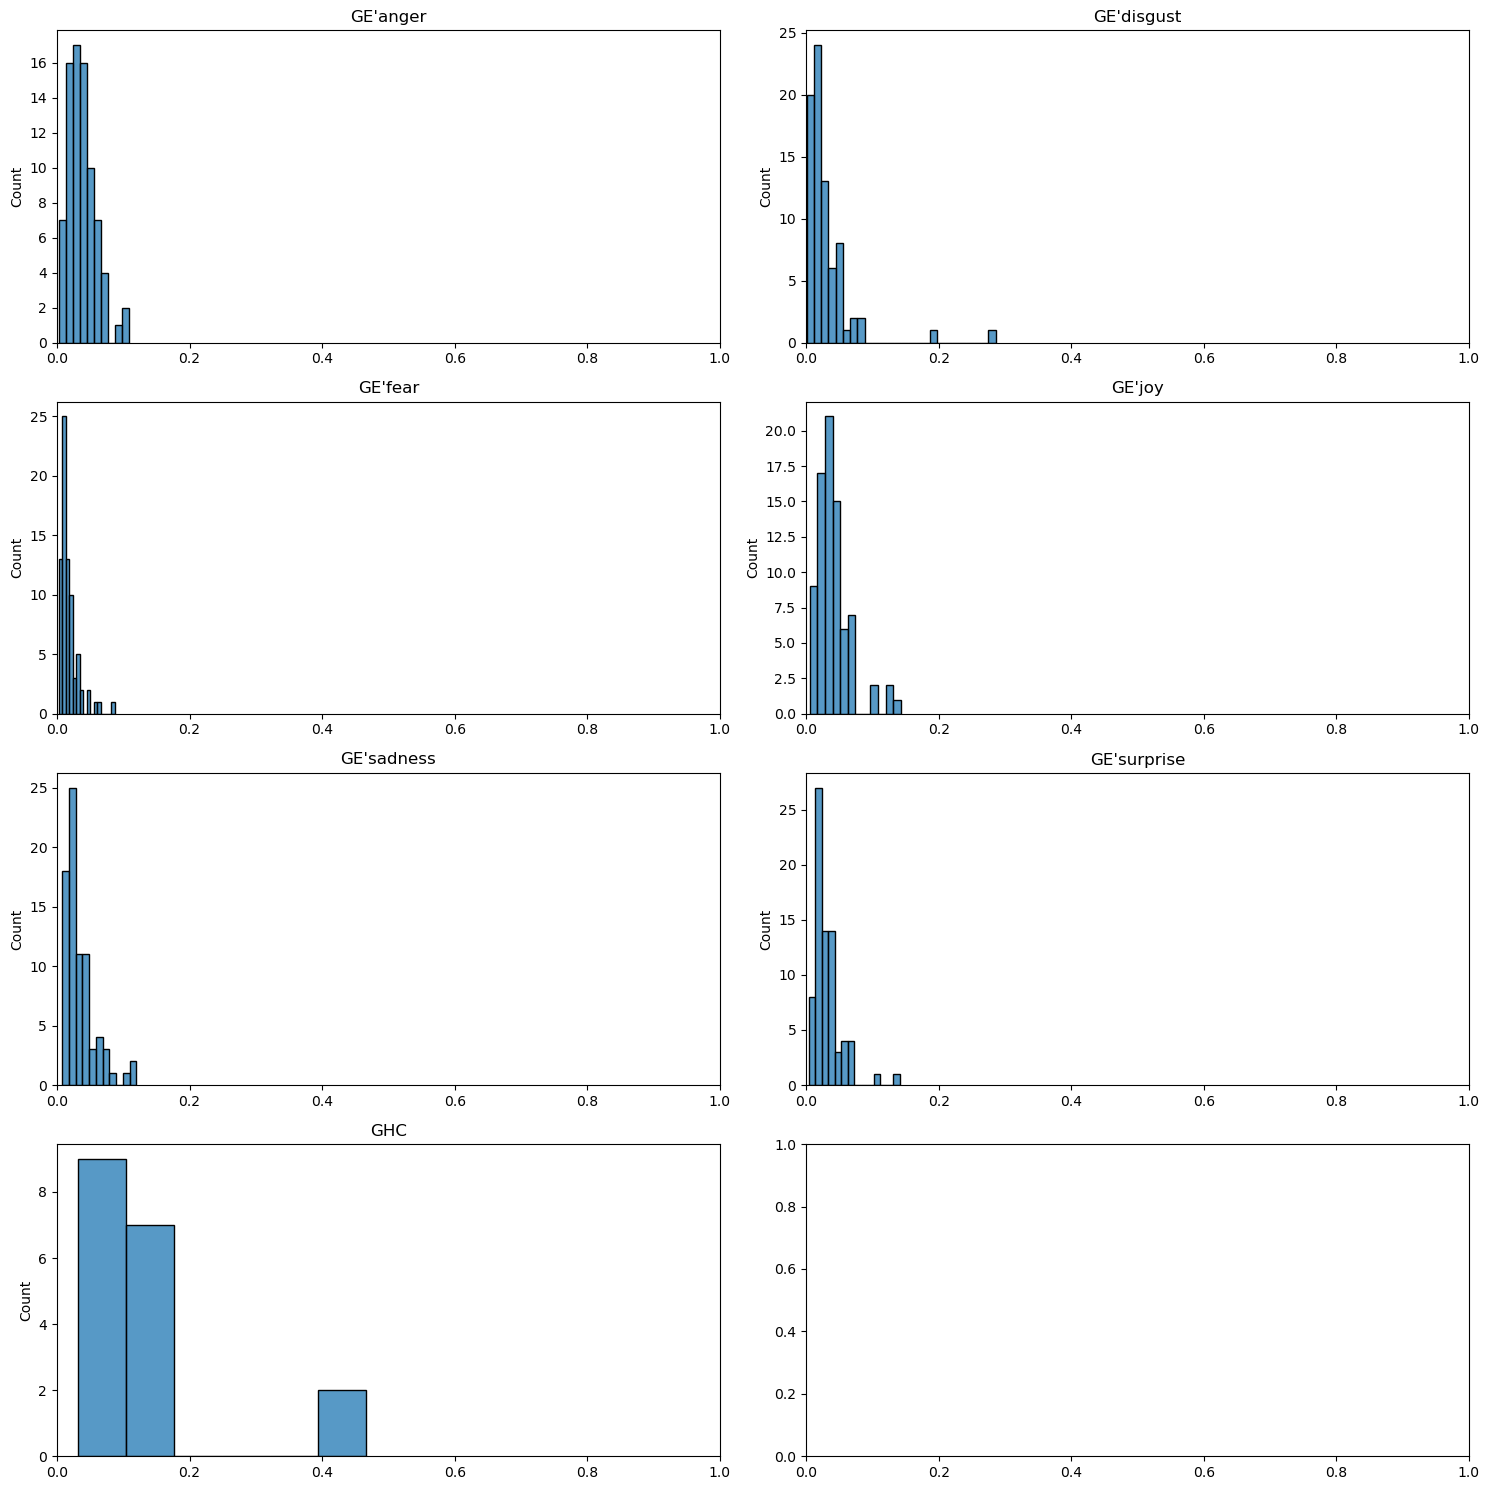

In [39]:
fig, axs = plt.subplots(figsize = (15, 15), nrows=4, ncols=2)
axs = axs.flatten()
for i, (df_name, ratios) in enumerate(ds_indi_ratios.items()):
    # h_plot = sns.histplot(ratios, ax=axs[i], bins=10)
    h_plot = sns.histplot(ratios, ax=axs[i])
    axs[i].set_title(df_name)
    axs[i].set(xlim=(0,1))
plt.tight_layout()

In [40]:
sc_annos_2500 = get_annos(sc_traversed_2500)

In [41]:
sc_anno_counts = sc_traversed_2500[sc_annos_2500].count()

In [42]:
sc_anno_counts = sc_traversed_2500[sc_annos_2500].count()

In [43]:
sc_anno_counts_sorted = sorted(sc_anno_counts, reverse=True)
sorted_sc_annos = sorted(sc_annos_2500, reverse=True, key= lambda x: sc_anno_counts_sorted[sc_annos_2500.index(x)])

In [49]:
sc_anno_counts_sorted[-20:]

[20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20]

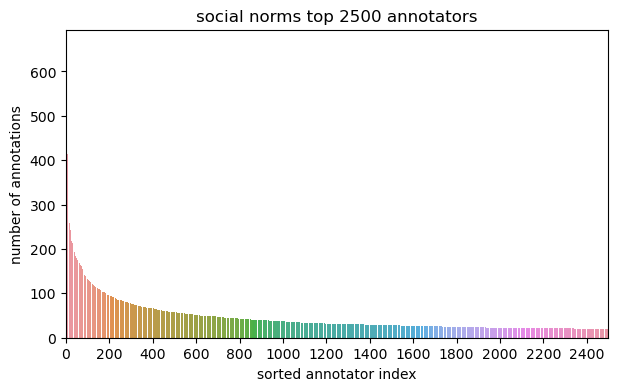

In [44]:
fig, ax = plt.subplots(figsize = (7, 4))
barplot = sns.barplot(x=sorted_sc_annos, y=sc_anno_counts_sorted, ax=ax)
barplot.set(xticklabels=[x if x%200==0 else None for x in range(0,2500)])
barplot.set(xticks=[x for x in range(0,2500) if x%200==0])
barplot.set(xlabel='sorted annotator index')
barplot.set(ylabel='number of annotations')
barplot.set(title='social norms top 2500 annotators')
plt.show()

<Axes: ylabel='Count'>

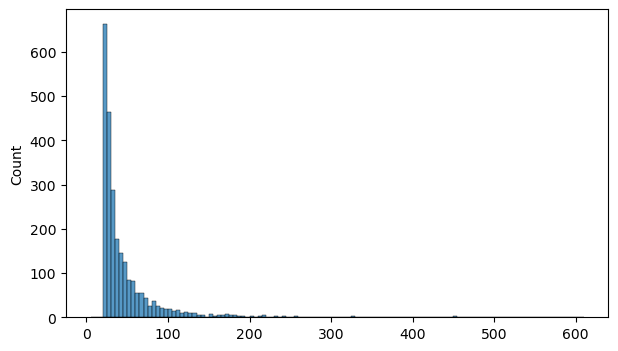

In [45]:
fig, ax = plt.subplots(figsize = (7, 4))
sns.histplot(sc_anno_counts_sorted, ax=ax, binwidth=5, binrange=[5,610])

In [46]:
ghc_counts = list(ghc_df[get_annos(ghc_df)].count())

In [180]:
ghc_annos = get_annos(ghc_df)

In [182]:
sorted_ghc = sorted(ghc_counts, reverse=True)
sorted_ghc_annos = sorted(ghc_annos, reverse=True, key= lambda x: sorted_ghc[ghc_annos.index(x)])

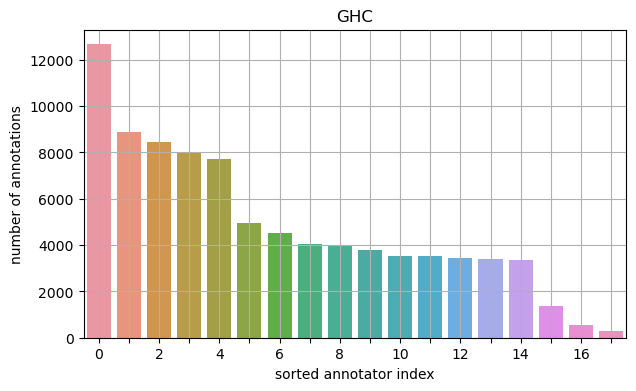

In [199]:
fig, ax = plt.subplots(figsize = (7, 4))
barplot = sns.barplot(x=sorted_ghc_annos, y=sorted_ghc, ax=ax)
barplot.set(xticklabels=[x if x%2==0 else '' for x in range(0,18)])
barplot.set(xlabel='sorted annotator index')
barplot.set(ylabel='number of annotations')
barplot.set(title='GHC')
ax.grid()
plt.show()

<Axes: ylabel='Count'>

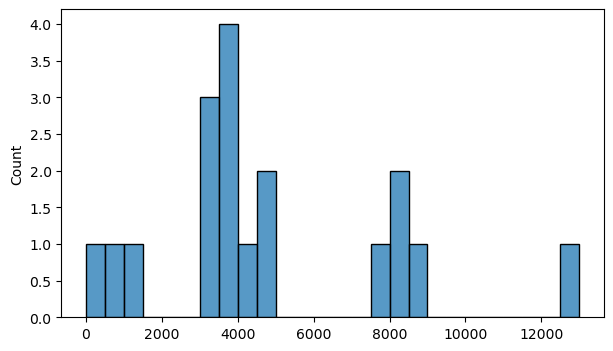

In [73]:
fig, ax = plt.subplots(figsize = (7, 4))
sns.histplot(ghc_counts, ax=ax, binwidth=500, binrange=[0,13000])

In [100]:
ge_annos = get_annos(ge_dfs['anger'])

In [107]:
ge_anger = ge_dfs['anger']

In [108]:
ge_counts = list(ge_anger[ge_annos].count())

In [127]:
sc_anno_counts_sorted[50:60]

[179, 177, 176, 175, 174, 174, 174, 172, 172, 171]

In [150]:
sorted_ge = sorted(ge_counts, reverse=True)
sorted_ge_annos = sorted(ge_annos, reverse=True, key= lambda x: sorted_ge[ge_annos.index(x)])

In [200]:
sorted_ge[49], sorted_ghc[13], sc_anno_counts_sorted[49]

(1587, 3400, 179)

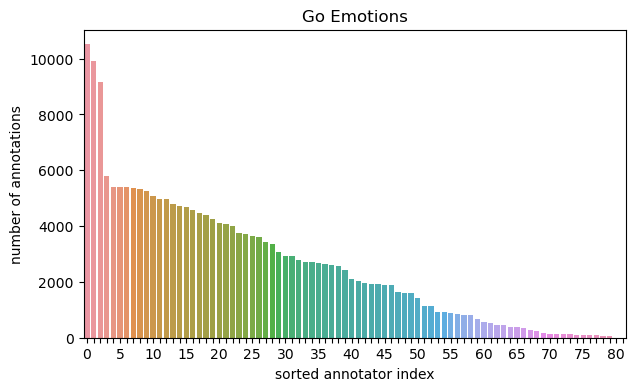

In [187]:
fig, ax = plt.subplots(figsize = (7, 4))
barplot = sns.barplot(x=sorted_ge_annos, y=sorted_ge, ax=ax)
barplot.set(xticklabels=[x if x%5==0 else '' for x in range(0,82)])
barplot.set(xlabel='sorted annotator index')
barplot.set(ylabel='number of annotations')
barplot.set(title='Go Emotions')
plt.show()

<Axes: ylabel='Count'>

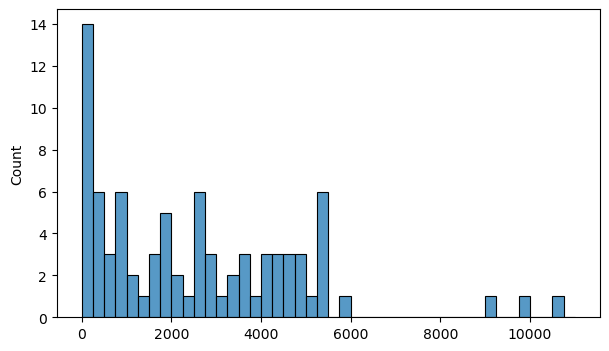

In [113]:
fig, ax = plt.subplots(figsize = (7, 4))
sns.histplot(ge_counts, ax=ax, binwidth=250, binrange=[0,11000])

In [125]:
def plot_annotations_per_anno_descending(df, tick_interval=5):
    annos = get_annos(df)
    counts = list(df[annos].count())
    
    sorted_counts = sorted(counts, reverse=True)
    sorted_annos = sorted(annos, reverse=True, key= lambda x: sorted_counts[annos.index(x)])
    
    fig, ax = plt.subplots(figsize = (7, 4))
    barplot = sns.barplot(x=sorted_annos, y=sorted_counts, ax=ax)
    barplot.set(xticklabels=[x if x%tick_interval==0 else '' for x in range(0,len(sorted_annos))])
    barplot.set(xticks=[x for x in range(0,len(sorted_annos)) if x%tick_interval==0])
    barplot.set(xlabel='sorted annotator index')
    barplot.set(ylabel='number of annotations')
    barplot.set(title='annotations per anno counts')
    ax.grid()
    plt.show()

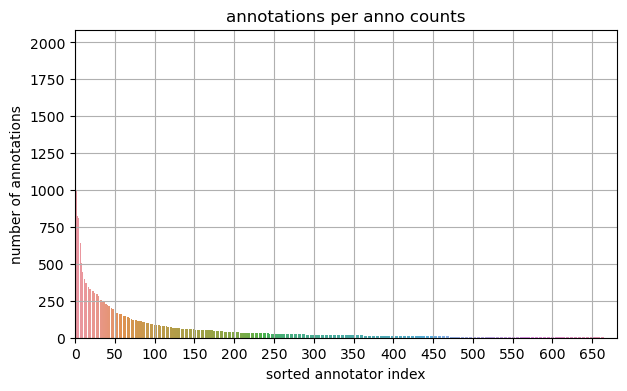

In [128]:
plot_annotations_per_anno_descending(mdd_df, tick_interval=50)

In [94]:
mdd_annos = get_annos(mdd_df)
mdd_counts = list(mdd_df[mdd_annos].count())

In [96]:
sorted_mdd = sorted(mdd_counts, reverse=True)
sorted_mdd_annos = sorted(mdd_annos, reverse=True, key= lambda x: sorted_mdd[mdd_annos.index(x)])

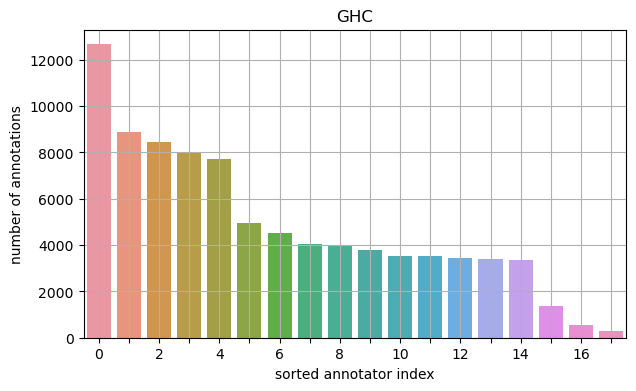

In [ ]:
fig, ax = plt.subplots(figsize = (7, 4))
barplot = sns.barplot(x=sorted_ghc_annos, y=sorted_ghc, ax=ax)
barplot.set(xticklabels=[x if x%2==0 else '' for x in range(0,18)])
barplot.set(xlabel='sorted annotator index')
barplot.set(ylabel='number of annotations')
barplot.set(title='GHC')
ax.grid()
plt.show()

# reduce

## Social Chemistry

In [22]:
sc_p = pd.read_csv(path_to_data+'social_norms_pivoted_min_20_per_annotator.csv')

In [23]:
print(sc_p.shape)
sc_p[:2]

(18493, 2522)


,parent_id,0,1,2,3,4,5,6,7,8,...,2511,2512,2513,2514,2515,2516,2517,2518,2519,2520
0,9t4mgu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9t4u6g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
sc_p = df_only_annos(sc_p)

In [25]:
print(sc_p.shape)
sc_p[:2]

(18493, 2521)


,0,1,2,3,4,5,6,7,8,9,...,2511,2512,2513,2514,2515,2516,2517,2518,2519,2520
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
sc_228 = reduce_df_to_k(sc_p,228)

print(sc_228.shape)

(18493, 24)


In [27]:
x = 180
sc_x = reduce_df_to_k(sc_p,x)

print(sc_x.shape)

(18493, 50)


<AxesSubplot: ylabel='Count'>

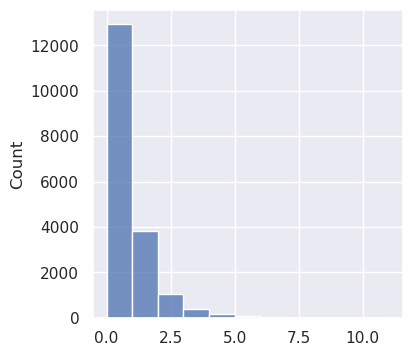

In [28]:
sns.set(rc={'figure.figsize':(4,4)})
sns.histplot(sc_228.count(axis=1), binwidth=1)

In [29]:
# filter by l=3 leaves us with too less posts
sc_100_3 = reduce_df_to_k_l(sc_p,100,3)
sc_100_3.shape

(882, 28)

In [30]:
sc_n_posts, sc_n_annos = get_n_posts_annos_of_ks(sc_p,list(range(20,250)))

In [31]:
highlights = [20,30,40,50,60,70,80,90,100,120,150,170,200,220,250]
sc_highlight_n_posts, sc_highlight_n_annos = get_n_posts_annos_of_ks(sc_p, highlights)

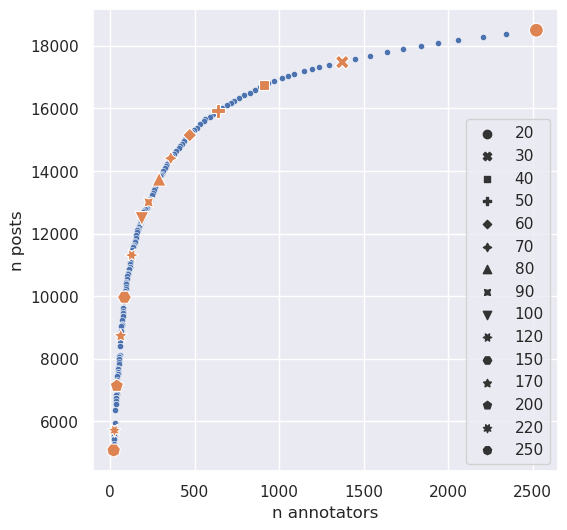

In [32]:
sns.set(rc={'figure.figsize':(6,6)})
ax = sns.scatterplot(y=sc_n_posts, x=sc_n_annos, legend=False, s=20)
ax2 = sns.scatterplot(y=sc_highlight_n_posts, x=sc_highlight_n_annos, legend=True, style=highlights, s=100).set()
ax.set(xlabel='n annotators', ylabel='n posts')
plt.show()

In [33]:
def authors_posts_df(l_vals,k_vals):
    df = pd.DataFrame(columns=['authors','posts','l','k'])
    for l in l_vals:
        for k in k_vals:
            reduced_df = reduce_df_to_k_l(sc_p,k,l)
            num_posts, num_authors = reduced_df.shape
            df.loc[len(df)] = [num_authors,num_posts,l,k]
    
    return df


In [34]:
l_values = [1,3,5,7]
k_values = [20,30,40,50,60,70,80,90,100,120,150,200,300,400,500]

df_to_print = authors_posts_df(l_values, k_values)

<AxesSubplot: xlabel='authors', ylabel='posts'>

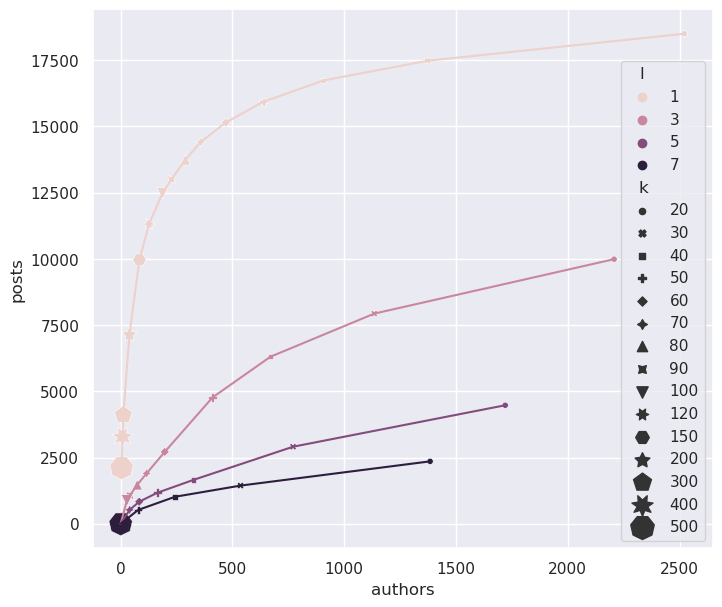

In [35]:
sns.set(rc={'figure.figsize':(8,7)})
sns.scatterplot(data=df_to_print, x="authors", y="posts", hue="l", size="k", sizes=(20,300), style='k', legend='full')
sns.lineplot(data=df_to_print, x="authors", y="posts", hue="l", legend=False)

In [36]:
l_values = [1,3,5,7]
k_values = [100,200,250,300,320,400]

df_to_print = authors_posts_df(l_values, k_values)

<AxesSubplot: xlabel='authors', ylabel='posts'>

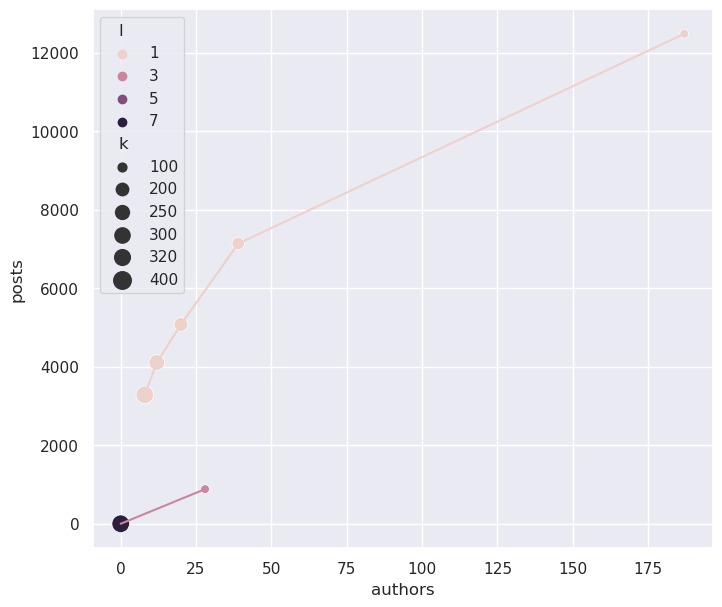

In [37]:
sns.set(rc={'figure.figsize':(8,7)})
sns.scatterplot(data=df_to_print, x="authors", y="posts", hue="l", size="k", sizes=(40,160), legend='full')
sns.lineplot(data=df_to_print, x="authors", y="posts", hue="l", legend=False)

## GoEmotions

In [38]:
path_to_emotions_data = '../data/GE_data/'

In [39]:
emotions = ['anger','disgust','fear','joy','sadness','surprise']
emotion = emotions[0]

In [40]:
emotion_df = pd.read_csv(path_to_emotions_data + emotion+'_multi.csv')

In [41]:
emotion_df.majority.value_counts()[1] / emotion_df.majority.value_counts()[0]

0.02618032583892024

In [42]:
emotion_df.shape

(58011, 85)

In [43]:
ge_df = df_only_annos(emotion_df)
ge_df.shape

(58011, 82)

In [44]:
# check if for all emotions the annoators have either labeled all or non.
for emo in emotions[1:]:
    emo_df = pd.read_csv(path_to_emotions_data + emo+'_multi.csv')
    annos = get_annos(emo_df)
    print(all(ge_df.notnull() == emo_df[annos].notnull()))

True
True


True
True
True


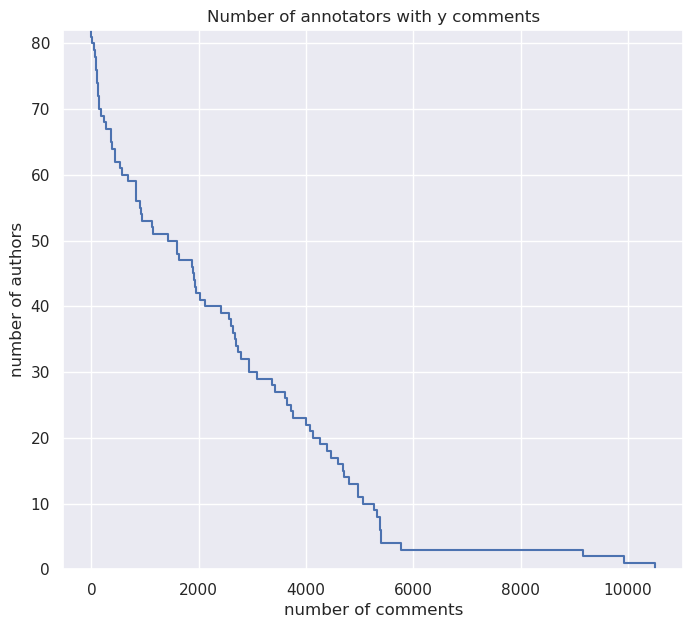

In [45]:
ax = sns.ecdfplot(data=ge_df.count(), complementary=True, stat='count')
ax.set(title=f'Number of annotators with y comments', xlabel='number of comments', ylabel='number of authors') 
plt.show()

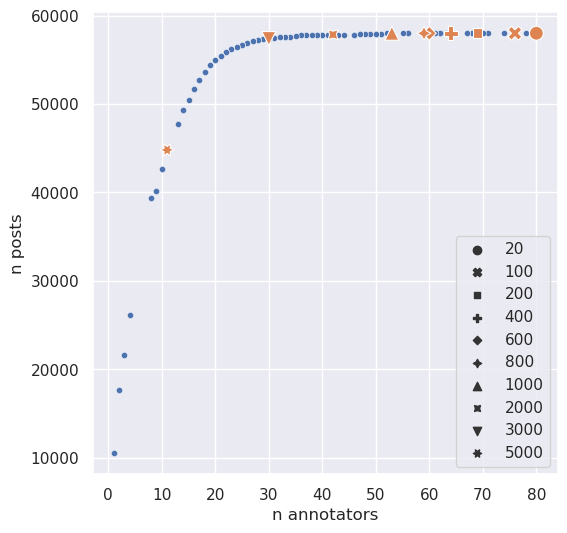

In [46]:
ge_n_posts, ge_n_annos = get_n_posts_annos_of_ks(ge_df,list(range(20,10000,20)))

highlights = [20,100,200,400,600,800,1000,2000,3000,5000]
ge_highlight_n_posts, ge_highlight_n_annos = get_n_posts_annos_of_ks(ge_df, highlights)

sns.set(rc={'figure.figsize':(6,6)})
ax = sns.scatterplot(y=ge_n_posts, x=ge_n_annos, legend=False, s=20)
ax2 = sns.scatterplot(y=ge_highlight_n_posts, x=ge_highlight_n_annos, legend=True, style=highlights, s=100).set()
ax.set(xlabel='n annotators', ylabel='n posts')
plt.show()

## GHC

In [47]:
path_to_ghc_data = '../data/GHC_data/'
ghc_df = pd.read_csv(path_to_ghc_data + 'hate_multi.csv')

In [48]:
ghc_df.majority.value_counts()[1] / ghc_df.majority.value_counts()[0]

0.1021034180543383

In [49]:
ghc_df.shape

(27665, 20)

In [50]:
annos = [c for c in ghc_df.columns if re.fullmatch(r'[0-9]+',c)]

In [51]:
ghc_df[annos].count().sum()

86529

In [52]:
ghc_df = df_only_annos(ghc_df)
ghc_df.shape

(27665, 18)

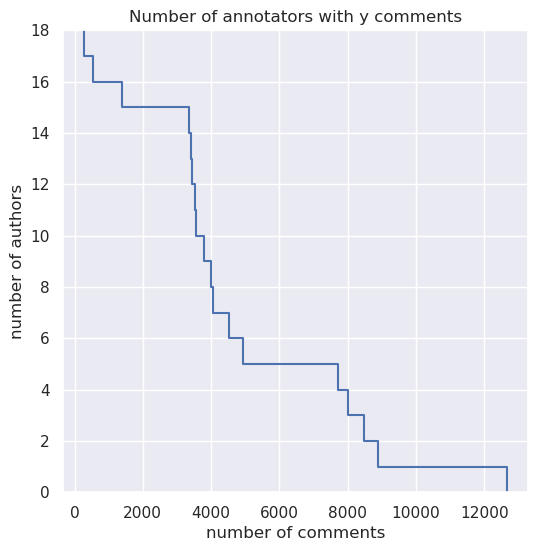

In [53]:
ax = sns.ecdfplot(data=ghc_df.count(), complementary=True, stat='count')
ax.set(title=f'Number of annotators with y comments', xlabel='number of comments', ylabel='number of authors') 
plt.show()

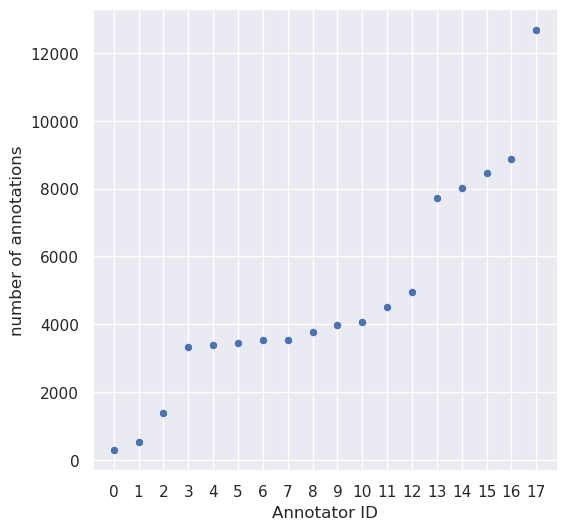

In [54]:
ax = sns.scatterplot(sorted(ghc_df.count()))
ax.set_xticks(list(range(18)))
ax.set(xlabel='Annotator ID', ylabel='number of annotations')
plt.show()

In [55]:
ghc_n_posts, ghc_n_annos = get_n_posts_annos_of_ks(ghc_df,list(range(20,12000,40)))

In [56]:
drops = [20]
for i, k in enumerate(list(range(20,12000,40))):
    if i == 0:
        continue
    if ghc_n_posts[i-1] > ghc_n_posts[i]:
        drops.append(k)

ghc_highlight_n_posts, ghc_highlight_n_annos = get_n_posts_annos_of_ks(ghc_df, drops)

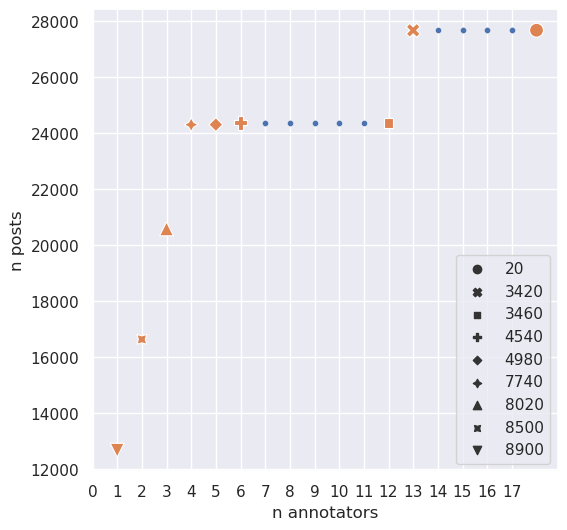

In [57]:
sns.set(rc={'figure.figsize':(6,6)})
ax = sns.scatterplot(y=ghc_n_posts, x=ghc_n_annos, legend=False, s=20)
ax2 = sns.scatterplot(y=ghc_highlight_n_posts, x=ghc_highlight_n_annos, legend=True, style=drops, s=100).set()
ax.set(xlabel='n annotators', ylabel='n posts', xticks=list(range(18)))
plt.show()

# TRAIN TEST SPLIT

### Summary
- doing a split with the stratification of the dealing with disagreement paper doesn't work anymore, because many stratification classes have only one element, resulting an error for sklearn stratified k fold. (the stratification is to use the combination of annotators that annotated on an instance as classes, see _encode_annotations_for_stratification() below)  
- checked if the ratios for each annotator of annotated 0s and 1s in the train and test set if significantly different from the ratio of the whole dataset. 
    - the ratios in the sets are the same

In [18]:
from utils.constants import SEEDS

In [86]:
# for rand_state in SEEDS:
#     for df, name in zip([ghc_df.copy(), ge_df.copy(), sc_df.copy()], ['GHC','GE','SC']):
#         k_fold_train_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_state)
#         train_split_ids, test_split_ids = next(iter(k_fold_train_test.split(X=df, y=df.majority)))

#         tr_df_maj = df.iloc[train_split_ids.tolist()]
#         test_df_maj = df.iloc[test_split_ids.tolist()]

#         k_fold_test_val = StratifiedKFold(n_splits=4, shuffle=True, random_state=rand_state)
#         train_split_ids_new, val_split_ids_new = next(iter(k_fold_test_val.split(X=tr_df_maj, y=tr_df_maj.majority)))

#         val_split_ids = train_split_ids[val_split_ids_new]
#         train_split_ids = train_split_ids[train_split_ids_new]

#         tr_df_maj = df.iloc[train_split_ids.tolist()]
#         val_df_maj = df.iloc[val_split_ids.tolist()]
        
#         tr_df_maj = tr_df_maj[['id']]
#         val_df_maj = val_df_maj[['id']]
#         test_df_maj = test_df_maj[['id']]
        
#         tr_df_maj.to_csv(f'../data/{name.upper()}_data/train_{name.lower()}_seed_{str(rand_state)}.csv', index=False)
#         val_df_maj.to_csv(f'../data/{name.upper()}_data/val_{name.lower()}_seed_{str(rand_state)}.csv', index=False)
#         test_df_maj.to_csv(f'../data/{name.upper()}_data/test_{name.lower()}_seed_{str(rand_state)}.csv', index=False)

### GHC

In [72]:
rand_state = 2222

df = ghc_df.copy()

In [73]:
k_fold_train_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_state)
train_split_ids, test_split_ids = next(iter(k_fold_train_test.split(X=df, y=df.majority)))

tr_df_maj = df.iloc[train_split_ids.tolist()]
test_df_maj = df.iloc[test_split_ids.tolist()]

k_fold_test_val = StratifiedKFold(n_splits=4, shuffle=True, random_state=rand_state)
train_split_ids_new, val_split_ids_new = next(iter(k_fold_test_val.split(X=tr_df_maj, y=tr_df_maj.majority)))

val_split_ids = train_split_ids[val_split_ids_new]
train_split_ids = train_split_ids[train_split_ids_new]

tr_df_maj = df.iloc[train_split_ids.tolist()]
val_df_maj = df.iloc[val_split_ids.tolist()]

In [354]:
annos = get_annos(tr_df_maj)

In [355]:
ration_maj = []
ration_maj_train = []
ration_maj_test = []
ration_maj_val = []
# corrected to percentage
num_annotations = []
num_annotations_train = []
num_annotations_test = []
num_annotations_val = []
for anno in annos:
    r = ghc_df[anno].value_counts()[0] / ghc_df[anno].value_counts()[1]
    ration_maj.append(r)
    r = tr_df_maj[anno].value_counts()[0] / tr_df_maj[anno].value_counts()[1]
    ration_maj_train.append(r)
    r = test_df_maj[anno].value_counts()[0] / test_df_maj[anno].value_counts()[1]
    ration_maj_test.append(r)
    r = val_df_maj[anno].value_counts()[0] / val_df_maj[anno].value_counts()[1]
    ration_maj_val.append(r)
    
    s = ghc_df[anno].count() / len(ghc_df)
    num_annotations.append(s)
    s = tr_df_maj[anno].count() / len(tr_df_maj)
    num_annotations_train.append(s)
    s = test_df_maj[anno].count() / len(test_df_maj)
    num_annotations_test.append(s)
    s = val_df_maj[anno].count() / len(val_df_maj)
    num_annotations_val.append(s)

In [356]:
ratios = [ration_maj, ration_maj_train, ration_maj_test, ration_maj_val]

/app/home/neuendob/anaconda3/envs/master/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<Axes: >

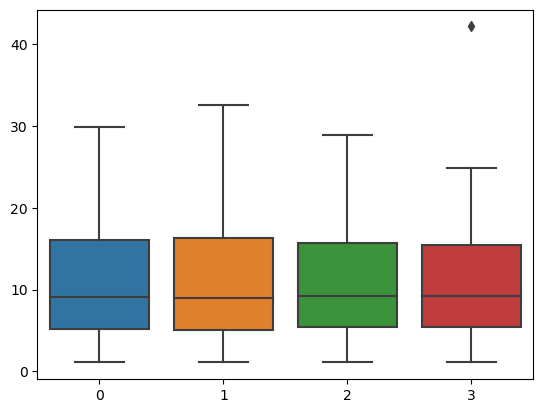

In [357]:
sns.boxplot(data = pd.DataFrame(ratios).transpose())

In [358]:
names = ['ration_maj', 'ration_maj_train', 'ration_maj_test', 'ration_maj_val']
n = len(ratios)

for i in range(n-1):
    for j in range(i+1,n):
        a,b = ratios[i], ratios[j]
        print('_'*20)
        print(names[i], names[j])
        print(stats.ttest_rel(a, b))
        _, p_greater = stats.ttest_rel(a, b, alternative='greater')
        _, p_less = stats.ttest_rel(a, b, alternative='less')
        print(p_greater, p_less)


____________________
ration_maj ration_maj_train
TtestResult(statistic=-0.5439575791056815, pvalue=0.5935337476167823, df=17)
0.7032331261916089 0.2967668738083912
____________________
ration_maj ration_maj_test
TtestResult(statistic=0.9083400193756002, pvalue=0.37639608543395064, df=17)
0.18819804271697532 0.8118019572830246
____________________
ration_maj ration_maj_val
TtestResult(statistic=-0.49900235355411193, pvalue=0.6241732012186045, df=17)
0.6879133993906976 0.31208660060930227
____________________
ration_maj_train ration_maj_test
TtestResult(statistic=1.0200342708560117, pvalue=0.3220098935014278, df=17)
0.1610049467507139 0.8389950532492861
____________________
ration_maj_train ration_maj_val
TtestResult(statistic=-0.30557723131026104, pvalue=0.763636650543978, df=17)
0.618181674728011 0.381818325271989
____________________
ration_maj_test ration_maj_val
TtestResult(statistic=-0.6536886055414523, pvalue=0.5220570658457679, df=17)
0.7389714670771159 0.26102853292288397


In [359]:
ratios = [ration_maj, ration_maj_train, ration_maj_test, ration_maj_val]

/app/home/neuendob/anaconda3/envs/master/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<Axes: >

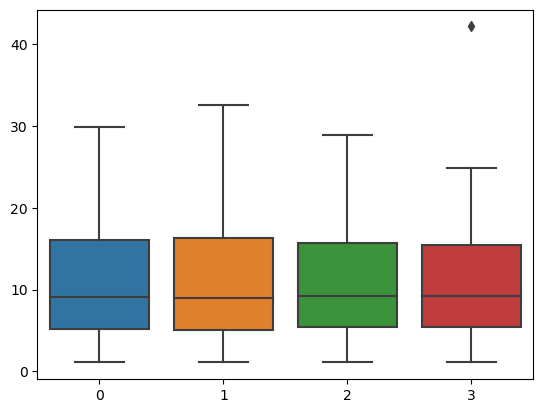

In [360]:
sns.boxplot(data = pd.DataFrame(ratios).transpose())

In [361]:

names = ['num_annotations', 'num_annotations_train', 'num_annotations_test', 'num_annotations_val']
n = len(ratios)

for i in range(n-1):
    for j in range(i+1,n):
        a,b = ratios[i], ratios[j]
        print('_'*20)
        print(names[i], names[j])
        print(stats.ttest_rel(a, b))
        _, p_greater = stats.ttest_rel(a, b, alternative='greater')
        _, p_less = stats.ttest_rel(a, b, alternative='less')
        print(p_greater, p_less)

____________________
num_annotations num_annotations_train
TtestResult(statistic=-0.5439575791056815, pvalue=0.5935337476167823, df=17)
0.7032331261916089 0.2967668738083912
____________________
num_annotations num_annotations_test
TtestResult(statistic=0.9083400193756002, pvalue=0.37639608543395064, df=17)
0.18819804271697532 0.8118019572830246
____________________
num_annotations num_annotations_val
TtestResult(statistic=-0.49900235355411193, pvalue=0.6241732012186045, df=17)
0.6879133993906976 0.31208660060930227
____________________
num_annotations_train num_annotations_test
TtestResult(statistic=1.0200342708560117, pvalue=0.3220098935014278, df=17)
0.1610049467507139 0.8389950532492861
____________________
num_annotations_train num_annotations_val
TtestResult(statistic=-0.30557723131026104, pvalue=0.763636650543978, df=17)
0.618181674728011 0.381818325271989
____________________
num_annotations_test num_annotations_val
TtestResult(statistic=-0.6536886055414523, pvalue=0.5220570658

In [362]:
tr_df_maj['id'] = tr_df_maj.index
test_df_maj['id'] = test_df_maj.index
val_df_maj['id'] = val_df_maj.index

/tmp/ipykernel_2660650/162725666.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr_df_maj['id'] = tr_df_maj.index
/tmp/ipykernel_2660650/162725666.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_maj['id'] = test_df_maj.index
/tmp/ipykernel_2660650/162725666.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [363]:
# tr_df_maj.to_csv('../data/GHC_data/train_ghc.csv', index=False)
# test_df_maj.to_csv('../data/GHC_data/test_ghc.csv', index=False)
# val_df_maj.to_csv('../data/GHC_data/val_ghc.csv', index=False)

### GE

In [19]:
rand_state = 2222

df = ge_df.copy()

In [27]:
# predefined:
df.index = df.id

train_all_ds = pd.read_csv(f'../data/GE_data/train_emotions.csv')
val_all_ds = pd.read_csv(f'../data/GE_data/val_emotions.csv')
test_all_ds = pd.read_csv(f'../data/GE_data/test_emotions.csv')
train_split_ids = list(train_all_ds.id)
val_split_ids = list(val_all_ds.id)
test_split_ids = list(test_all_ds.id)

test_df_maj = df.loc[test_split_ids]
tr_df_maj = df.loc[train_split_ids]
val_df_maj = df.loc[val_split_ids]

In [29]:
annos = get_annos(tr_df_maj)

In [30]:
# ration_maj = []
# ration_maj_train = []
# ration_maj_test = []
# ration_maj_val = []
# corrected to percentage
num_annotations = []
num_annotations_train = []
num_annotations_test = []
num_annotations_val = []
for anno in annos:
    # r = ge_df[anno].value_counts()[0] / ge_df[anno].value_counts()[1]
    # ration_maj.append(r)
    # r = tr_df_maj[anno].value_counts()[0] / tr_df_maj[anno].value_counts()[1]
    # ration_maj_train.append(r)
    # r = test_df_maj[anno].value_counts()[0] / test_df_maj[anno].value_counts()[1]
    # ration_maj_test.append(r)
    # r = val_df_maj[anno].value_counts()[0] / val_df_maj[anno].value_counts()[1]
    # ration_maj_val.append(r)
    
    s = ge_df[anno].count() / len(ge_df)
    num_annotations.append(s)
    s = tr_df_maj[anno].count() / len(tr_df_maj)
    num_annotations_train.append(s)
    s = test_df_maj[anno].count() / len(test_df_maj)
    num_annotations_test.append(s)
    s = val_df_maj[anno].count() / len(val_df_maj)
    num_annotations_val.append(s)

/app/home/neuendob/anaconda3/envs/master/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<Axes: >

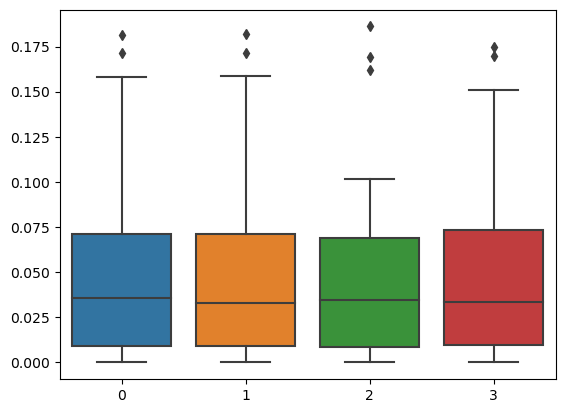

In [31]:
ratios = [num_annotations, num_annotations_train, num_annotations_test, num_annotations_val]
sns.boxplot(data=pd.DataFrame(ratios).transpose())

In [32]:

names = ['num_annotations', 'num_annotations_train', 'num_annotations_test', 'num_annotations_val']
n = len(ratios)

for i in range(n-1):
    for j in range(i+1,n):
        a,b = ratios[i], ratios[j]
        print('_'*20)
        print(names[i], names[j])
        print(stats.ttest_rel(a, b))
        _, p_greater = stats.ttest_rel(a, b, alternative='greater')
        _, p_less = stats.ttest_rel(a, b, alternative='less')
        print(p_greater, p_less)

____________________
num_annotations num_annotations_train
TtestResult(statistic=3.2524969171890006, pvalue=0.0016688624705714062, df=81)
0.0008344312352857031 0.9991655687647143
____________________
num_annotations num_annotations_test
TtestResult(statistic=1.9761090636219798, pvalue=0.051546699578021736, df=81)
0.025773349789010868 0.9742266502109892
____________________
num_annotations num_annotations_val
TtestResult(statistic=1.8726519188090016, pvalue=0.06472458205437329, df=81)
0.03236229102718664 0.9676377089728134
____________________
num_annotations_train num_annotations_test
TtestResult(statistic=-0.2428636049888612, pvalue=0.808725003375542, df=81)
0.595637498312229 0.404362501687771
____________________
num_annotations_train num_annotations_val
TtestResult(statistic=-0.020676378900057867, pvalue=0.9835546607436182, df=81)
0.508222669628191 0.4917773303718091
____________________
num_annotations_test num_annotations_val
TtestResult(statistic=0.1448359024282932, pvalue=0.8852

In [43]:
df = ge_df.copy()

k_fold_train_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_state)
train_split_ids, test_split_ids = next(iter(k_fold_train_test.split(X=df, y=df.majority)))

tr_df_maj = df.iloc[train_split_ids.tolist()]
test_df_maj = df.iloc[test_split_ids.tolist()]

k_fold_test_val = StratifiedKFold(n_splits=4, shuffle=True, random_state=rand_state)
train_split_ids_new, val_split_ids_new = next(iter(k_fold_test_val.split(X=tr_df_maj, y=tr_df_maj.majority)))

val_split_ids = train_split_ids[val_split_ids_new]
train_split_ids = train_split_ids[train_split_ids_new]

tr_df_maj = df.iloc[train_split_ids.tolist()]
val_df_maj = df.iloc[val_split_ids.tolist()]

In [44]:
annos = get_annos(tr_df_maj)

In [45]:
# ration_maj = []
# ration_maj_train = []
# ration_maj_test = []
# ration_maj_val = []
# corrected to percentage
num_annotations = []
num_annotations_train = []
num_annotations_test = []
num_annotations_val = []
for anno in annos:
    # r = ge_df[anno].value_counts()[0] / ge_df[anno].value_counts()[1]
    # ration_maj.append(r)
    # r = tr_df_maj[anno].value_counts()[0] / tr_df_maj[anno].value_counts()[1]
    # ration_maj_train.append(r)
    # r = test_df_maj[anno].value_counts()[0] / test_df_maj[anno].value_counts()[1]
    # ration_maj_test.append(r)
    # r = val_df_maj[anno].value_counts()[0] / val_df_maj[anno].value_counts()[1]
    # ration_maj_val.append(r)
    
    s = ge_df[anno].count() / len(ge_df)
    num_annotations.append(s)
    s = tr_df_maj[anno].count() / len(tr_df_maj)
    num_annotations_train.append(s)
    s = test_df_maj[anno].count() / len(test_df_maj)
    num_annotations_test.append(s)
    s = val_df_maj[anno].count() / len(val_df_maj)
    num_annotations_val.append(s)

/app/home/neuendob/anaconda3/envs/master/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<Axes: >

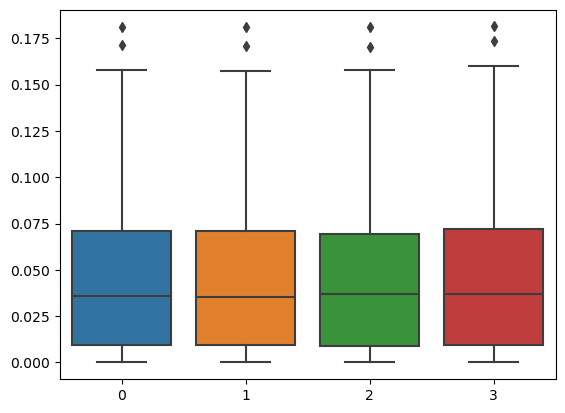

In [46]:
ratios = [num_annotations, num_annotations_train, num_annotations_test, num_annotations_val]
sns.boxplot(data=pd.DataFrame(ratios).transpose())

In [47]:

names = ['num_annotations', 'num_annotations_train', 'num_annotations_test', 'num_annotations_val']
n = len(ratios)

for i in range(n-1):
    for j in range(i+1,n):
        a,b = ratios[i], ratios[j]
        print('_'*20)
        print(names[i], names[j])
        print(stats.ttest_rel(a, b))
        _, p_greater = stats.ttest_rel(a, b, alternative='greater')
        _, p_less = stats.ttest_rel(a, b, alternative='less')
        print(p_greater, p_less)

____________________
num_annotations num_annotations_train
TtestResult(statistic=0.6600187409964923, pvalue=0.5111142761488447, df=81)
0.2555571380744224 0.7444428619255776
____________________
num_annotations num_annotations_test
TtestResult(statistic=-0.5060962403814375, pvalue=0.6141637713287956, df=81)
0.6929181143356022 0.3070818856643978
____________________
num_annotations num_annotations_val
TtestResult(statistic=-0.2825692297908797, pvalue=0.7782278805560358, df=81)
0.6108860597219821 0.3891139402780179
____________________
num_annotations_train num_annotations_test
TtestResult(statistic=-0.6118347810560039, pvalue=0.5423606479747147, df=81)
0.7288196760126426 0.27118032398735736
____________________
num_annotations_train num_annotations_val
TtestResult(statistic=-0.4175464768990765, pvalue=0.677383459572275, df=81)
0.6613082702138626 0.3386917297861375
____________________
num_annotations_test num_annotations_val
TtestResult(statistic=0.11767580564666635, pvalue=0.90661585134

In [379]:
# tr_df_maj.to_csv('../data/GE_data/train_ge.csv')
# test_df_maj.to_csv('../data/GE_data/test_ge.csv')
# val_df_maj.to_csv('../data/GE_data/val_ge.csv')

### SC

In [380]:
sc_df = filter_df_min_annotation_and_update_majority(sc_df,1)

In [381]:
sc_df.shape

(18493, 2524)

In [382]:
rand_state = 2222

df = sc_df.copy()

In [383]:
k_fold_train_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_state)
train_split_ids, test_split_ids = next(iter(k_fold_train_test.split(X=df, y=df.majority)))

tr_df_maj = df.iloc[train_split_ids.tolist()]
test_df_maj = df.iloc[test_split_ids.tolist()]

k_fold_test_val = StratifiedKFold(n_splits=4, shuffle=True, random_state=rand_state)
train_split_ids_new, val_split_ids_new = next(iter(k_fold_test_val.split(X=tr_df_maj, y=tr_df_maj.majority)))

val_split_ids = train_split_ids[val_split_ids_new]
train_split_ids = train_split_ids[train_split_ids_new]

tr_df_maj = df.iloc[train_split_ids.tolist()]
val_df_maj = df.iloc[val_split_ids.tolist()]

In [384]:
annos = get_annos(tr_df_maj)

In [385]:
# ration_maj = []
# ration_maj_train = []
# ration_maj_test = []
# ration_maj_val = []

num_annotations = []
num_annotations_train = []
num_annotations_test = []
num_annotations_val = []
# corrected to percentage
rat_annotations = []
rat_annotations_train = []
rat_annotations_test = []
rat_annotations_val = []
for anno in annos:
    # try:
    #     r = sc_df[anno].value_counts()[0] / sc_df[anno].value_counts()[1]
    #     ration_maj.append(r)
    # except:
    #     pass
    # try:
    #     r = tr_df_maj[anno].value_counts()[0] / tr_df_maj[anno].value_counts()[1]
    #     ration_maj_train.append(r)
    # except:
    #     pass
    # try:
    #     r = test_df_maj[anno].value_counts()[0] / test_df_maj[anno].value_counts()[1]
    #     ration_maj_test.append(r)
    # except:
    #     pass
    # try:
    #     r = val_df_maj[anno].value_counts()[0] / val_df_maj[anno].value_counts()[1]
    #     ration_maj_val.append(r)
    # except:
    #     pass
    
    s = sc_df[anno].count()
    num_annotations.append(s)
    s = tr_df_maj[anno].count()
    num_annotations_train.append(s)
    s = test_df_maj[anno].count()
    num_annotations_test.append(s)
    s = val_df_maj[anno].count()
    num_annotations_val.append(s)
    
    s = sc_df[anno].count() / len(sc_df)
    rat_annotations.append(s)
    s = tr_df_maj[anno].count() / len(tr_df_maj)
    rat_annotations_train.append(s)
    s = test_df_maj[anno].count() / len(test_df_maj)
    rat_annotations_test.append(s)
    s = val_df_maj[anno].count() / len(val_df_maj)
    rat_annotations_val.append(s)

/app/home/neuendob/anaconda3/envs/master/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<Axes: >

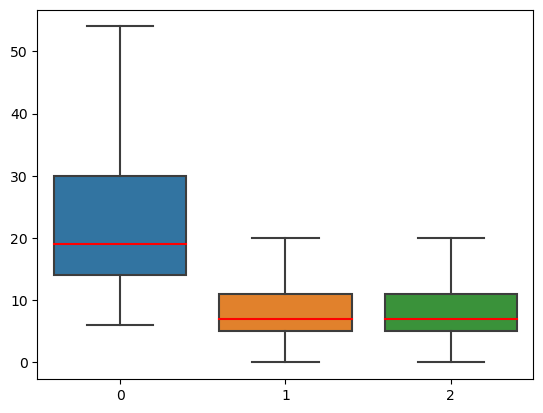

In [386]:
nums = [num_annotations_train, num_annotations_test, num_annotations_val]
sns.boxplot(data=pd.DataFrame(nums).transpose(), showfliers = False, medianprops=dict(color="red"))

/app/home/neuendob/anaconda3/envs/master/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<Axes: >

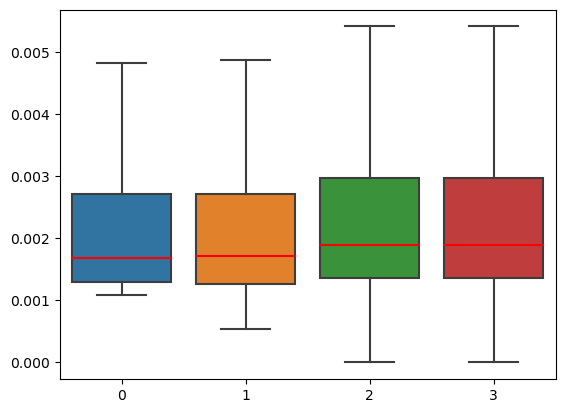

In [387]:
rats = [rat_annotations, rat_annotations_train, rat_annotations_test, rat_annotations_val]
sns.boxplot(data=pd.DataFrame(rats).transpose(), showfliers = False, medianprops=dict(color="red"))

In [388]:

names = ['num_annotations', 'num_annotations_train', 'num_annotations_test', 'num_annotations_val']
n = len(ratios)

for i in range(n-1):
    for j in range(i+1,n):
        a,b = ratios[i], ratios[j]
        print('_'*20)
        print(names[i], names[j])
        print(stats.ttest_rel(a, b))
        _, p_greater = stats.ttest_rel(a, b, alternative='greater')
        _, p_less = stats.ttest_rel(a, b, alternative='less')
        print(p_greater, p_less)

____________________
num_annotations num_annotations_train
TtestResult(statistic=0.6600187409964923, pvalue=0.5111142761488447, df=81)
0.2555571380744224 0.7444428619255776
____________________
num_annotations num_annotations_test
TtestResult(statistic=-0.5060962403814375, pvalue=0.6141637713287956, df=81)
0.6929181143356022 0.3070818856643978
____________________
num_annotations num_annotations_val
TtestResult(statistic=-0.2825692297908797, pvalue=0.7782278805560358, df=81)
0.6108860597219821 0.3891139402780179
____________________
num_annotations_train num_annotations_test
TtestResult(statistic=-0.6118347810560039, pvalue=0.5423606479747147, df=81)
0.7288196760126426 0.27118032398735736
____________________
num_annotations_train num_annotations_val
TtestResult(statistic=-0.4175464768990765, pvalue=0.677383459572275, df=81)
0.6613082702138626 0.3386917297861375
____________________
num_annotations_test num_annotations_val
TtestResult(statistic=0.11767580564666635, pvalue=0.90661585134

In [390]:
# tr_df_maj.to_csv('../data/SC_data/train_sc.csv', index=False)
# test_df_maj.to_csv('../data/SC_data/test_sc.csv', index=False)
# val_df_maj.to_csv('../data/SC_data/val_sc.csv', index=False)

### results:

In [ ]:
dfs = []
for ds_name in ['ghc','ge','sc']:
    train_all_ds = pd.read_csv(f'../data/{ds_name.upper()}_data/train_{ds_name}.csv')
    val_all_ds = pd.read_csv(f'../data/{ds_name.upper()}_data/val_{ds_name}.csv')
    test_all_ds = pd.read_csv(f'../data/{ds_name.upper()}_data/test_{ds_name}.csv')
    train_all_ds['split'] = 'train'
    val_all_ds['split'] = 'val'
    test_all_ds['split'] = 'test'
    all_df = pd.concat([train_all_ds, val_all_ds, test_all_ds])
    all_df['dataset'] = ds_name
    dfs.append(all_df)
    
    # sns.countplot(data=all_df, x='majority',hue='split')
    # plt.show()

In [ ]:
all_df = pd.concat(dfs)
all_df['data_majority'] = all_df['majority'].astype(str)  + '_' + all_df['dataset'].upper()
sns.countplot(data=all_df, x='data_majority', hue='split')

### check individual:

In [117]:
dataframe = pd.read_csv('../data/matching_sizes_data/GHC*full_14_annos_filtered.csv', index_col='Unnamed: 0')
dataframe['id'] = dataframe.index

In [118]:
dataframe[dataframe.id.isin(list(range(10)))]

,text,0,7,1,2,3,4,5,6,9,10,11,12,13,17,majority,id
0,Can't wait to see that Monday.,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,If you are from #Europe and care about #freeSp...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0,1
2,#FREESAMHYDE http://www.thegatewaypundit.com/2...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0,2
3,most disgusting people: - third worlders - gay...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,1.0,1,3
4,"JUST FOUND OUT BLACKS CONTROL THE GOVERNMENT, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,4
5,challenge: argue against any part of Kaczynski...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0,5
6,He WILL be imprisoned. This IS political. Tomm...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0,6
7,yeah im sure that's what prompted them to do it,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0,7
8,"New band names, by me: - Gay Retards on Fire -...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,1.0,1,8
9,'Is fucking a retarded girl rape? Asking for a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,1,9


In [119]:
ds_name = 'ghc'
train_all_ds = pd.read_csv(f'../data/{ds_name.upper()}_data/train_{ds_name}.csv')
val_all_ds = pd.read_csv(f'../data/{ds_name.upper()}_data/val_{ds_name}.csv')
test_all_ds = pd.read_csv(f'../data/{ds_name.upper()}_data/test_{ds_name}.csv')

In [120]:
train_all_ds[train_all_ds.id.isin(list(range(10)))]

,text,0,7,1,2,3,4,5,6,8,...,10,11,12,13,14,15,16,17,majority,id
0,Can't wait to see that Monday.,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,If you are from #Europe and care about #freeSp...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,1
2,most disgusting people: - third worlders - gay...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1,3
3,"JUST FOUND OUT BLACKS CONTROL THE GOVERNMENT, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0,4
4,challenge: argue against any part of Kaczynski...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0,5
5,He WILL be imprisoned. This IS political. Tomm...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,6
6,yeah im sure that's what prompted them to do it,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0,7
7,"New band names, by me: - Gay Retards on Fire -...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1,8
8,'Is fucking a retarded girl rape? Asking for a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1,9


In [182]:
36 in train_all_ds.id, 36 in test_all_ds.id, 36 in val_all_ds.id

(True, True, True)

In [188]:
a = train_all_ds.id.to_list()
b = val_all_ds.id.to_list()
c = test_all_ds.id.to_list()

In [121]:
comments_percentage = 100

train_ds = dataframe[dataframe.id.isin(train_all_ds.id)]
val_ds = dataframe[dataframe.id.isin(val_all_ds.id)]
test_ds = dataframe[dataframe.id.isin(test_all_ds.id)]
train_ds = reduce_df_to_min_num_annos(train_ds, comments_percentage)
# val_ds = reduce_df_to_min_num_annos(val_ds, comments_percentage)
# test_ds = reduce_df_to_min_num_annos(test_ds, comments_percentage)

train_ids = list(train_ds.id)
val_ids = list(val_ds.id)
test_ids = list(test_ds.id)

num_comments_per_anno_train = min(train_ds.count())

dataframe = pd.concat([train_ds, val_ds, test_ds])

dataframe = dataframe.replace(float('nan'), -1)
    
dataframe = filter_df_min_annotation_and_update_majority(dataframe, 1)

annotator_ids = [
    x for x in dataframe.columns if re.fullmatch(r'[0-9]+', x)]

# if task == 'single':
#     # dataframe[['id', 'text', 'majority']]
#     dataframe = dataframe[['text', 'majority']]
#     dataframe['0'] = dataframe['majority']

dataframe = dataframe.convert_dtypes()

tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-cased")
dataset = MultiTaskDataset(
    dataframe, tokenizer=tokenizer, max_length=64)

In [177]:
train_ds.loc[36,:]

text        That Titans trailer looked like shit.
0                                             NaN
7                                             NaN
1                                             NaN
2                                             0.0
3                                             NaN
4                                             NaN
5                                             NaN
6                                             NaN
9                                             NaN
10                                            NaN
11                                            NaN
12                                            0.0
13                                            0.0
17                                            NaN
majority                                        0
id                                             36
Name: 36, dtype: object

In [183]:
val_ds.loc[36,:]

KeyError: 36

In [175]:
test_ds.loc[36,:]

text        That Titans trailer looked like shit.
0                                             NaN
7                                             NaN
1                                             NaN
2                                             0.0
3                                             NaN
4                                             NaN
5                                             NaN
6                                             NaN
9                                             NaN
10                                            NaN
11                                            NaN
12                                            0.0
13                                            0.0
17                                            NaN
majority                                        0
id                                             36
Name: 36, dtype: object

In [128]:
dataset.texts.dtypes

string[python]

In [123]:
batch_size = 16
train_sampler = SubsetRandomSampler(train_ids)
val_sampler = SubsetRandomSampler(val_ids)
test_sampler = SubsetRandomSampler(test_ids)
train_loader = DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(
    dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler)

In [137]:
dataset.texts[:10]

0                        Can't wait to see that Monday.
1     If you are from #Europe and care about #freeSp...
3     most disgusting people: - third worlders - gay...
4     JUST FOUND OUT BLACKS CONTROL THE GOVERNMENT, ...
5     challenge: argue against any part of Kaczynski...
6     He WILL be imprisoned. This IS political. Tomm...
7       yeah im sure that's what prompted them to do it
8     New band names, by me: - Gay Retards on Fire -...
9     'Is fucking a retarded girl rape? Asking for a...
12    The mayor of Philadelphia has  blood on his ha...
Name: text, dtype: string

In [160]:
dataset.texts[20:30]

29    BOOM  MEXICO SENT TWO 727's FULL OF FEDERALIS ...
31    Good!  It’s about damn time there are conseque...
32    The delusion of the oppressed is one of moral ...
33                                 Dog and pony show ;D
34    He looks like an extra from Black Hole Sun, So...
35    where's that clock boy, obama invited 2 White ...
36                That Titans trailer looked like shit.
38    NATO is lying, again. Merkel has unlimited cri...
40    The right is shifting into a 'taking scalps' m...
42    Gonna be really fun when Disney fires Kathleen...
Name: text, dtype: string

In [167]:
dataset.texts[36]

'36    That Titans trailer looked like shit.\n36    That Titans trailer looked like shit.\nName: text, dtype: string'

In [133]:
dataset.__getitem__(36)

ValueError: Input 36    That Titans trailer looked like shit.
36    That Titans trailer looked like shit.
Name: text, dtype: string is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.

In [124]:
for i, data_dict in enumerate(train_loader):
    print(i)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/app/home/neuendob/anaconda3/envs/master/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


ValueError: Input 12655    I’d like to think that’s the end of Europe. Bu...
12655    I’d like to think that’s the end of Europe. Bu...
Name: text, dtype: string is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.

# SC, GHC, GE together

In [58]:
sc_n_posts, sc_n_annos = get_n_posts_annos_of_ks(sc_p,list(range(180,800,10)))
ge_n_posts, ge_n_annos = get_n_posts_annos_of_ks(ge_df,list(range(20,10000,40)))
ghc_n_posts, ghc_n_annos = get_n_posts_annos_of_ks(ghc_df,list(range(20,12000,40)))

In [53]:
highlights = [200,300,400,500,800,2000,3000,4000,5000]
sc_highlight_n_posts, sc_highlight_n_annos = get_n_posts_annos_of_ks(sc_p, highlights)
ghc_highlight_n_posts, ghc_highlight_n_annos = get_n_posts_annos_of_ks(ghc_df, highlights)
ge_highlight_n_posts, ge_highlight_n_annos = get_n_posts_annos_of_ks(ge_df, highlights)

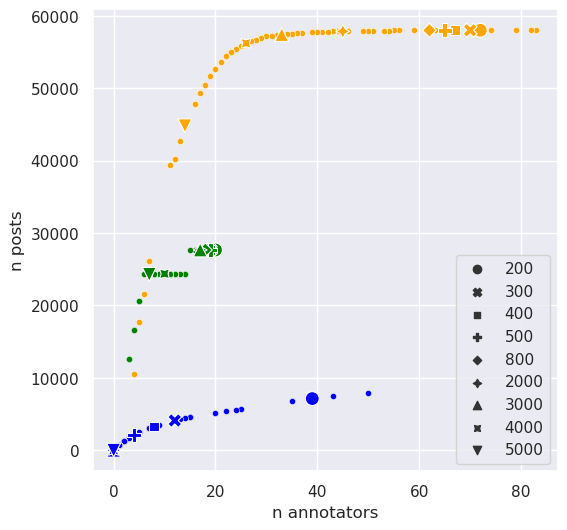

In [54]:
sns.set(rc={'figure.figsize':(6,6)})
ax1 = sns.scatterplot(y=sc_n_posts, x=sc_n_annos, legend=True, s=20, color='blue')
ax2 = sns.scatterplot(y=ge_n_posts, x=ge_n_annos, legend=False, s=20, color='orange')
ax3 = sns.scatterplot(y=ghc_n_posts, x=ghc_n_annos, legend=False, s=20, color='green')
ax4 = sns.scatterplot(y=sc_highlight_n_posts, x=sc_highlight_n_annos, legend=False, style=highlights, s=100, color='blue')
ax5 = sns.scatterplot(y=ghc_highlight_n_posts, x=ghc_highlight_n_annos, legend=True, style=highlights, s=100, color='green')
ax6 = sns.scatterplot(y=ge_highlight_n_posts, x=ge_highlight_n_annos, legend=False, style=highlights, s=100, color='orange')
ax1.set(xlabel='n annotators', ylabel='n posts')
plt.show()

# find match of dataframes

In [195]:
sc_copy, ge_copy, ghc_copy = sc_df.copy(), ge_df.copy(), ghc_df.copy()

In [196]:
sc_copy.shape, ge_copy.shape, ghc_copy.shape

((18452, 2521), (58011, 86), (27665, 21))

In [197]:
ress = {}

In [198]:
# algorithm for matching sizes

path_to_data_match = f"{path_to_data}matching_sizes_data/"

for num_annos in sorted([6, 8, 10, 12, 14, 16, 18] + list(range(22, 83, 4)) + list(range(100, 1000, 100)) + list(range(1000, 2510, 300)), reverse=True):
    print('#'*50)
    sc_copy = reduce_to_num_annos_by_remove_min(sc_copy, num_annos)
    # ge_copy = reduce_to_num_annos_by_remove_min(ge_copy, num_annos)
    # ghc_copy = reduce_to_num_annos_by_remove_min(ghc_copy, num_annos)
    
    print(sc_copy.shape, ge_copy.shape, ghc_copy.shape)
    
    num_posts = min([len(x) for x in [sc_copy, ghc_copy, ge_copy]])
    
    # print(num_posts)
    
    # sc_copy = reduce_df_to_k_num_annos_num_post(sc_copy,1,1,num_annos,num_posts)
    # ge_copy = reduce_df_to_k_num_annos_num_post(ge_copy,1,1,num_annos,num_posts)
    # ghc_copy = reduce_df_to_k_num_annos_num_post(ghc_copy,50,1,num_annos,num_posts)
    
    # print(sc_copy.shape, ge_copy.shape, ghc_copy.shape)
    
    # ress[f'ge_{num_annos}'] = ge_copy.copy()
    ress[f'sc_{num_annos}'] = sc_copy.copy()
    
    sc_copy.to_csv(path_to_data_match+f'sc_{num_annos}_annos_filtered.csv')
    # ge_copy.to_csv(path_to_data_match+f'GE_{num_annos}_annos_filtered.csv')
    # ghc_copy.to_csv(path_to_data_match+f'GHC_{num_annos}_annos_filtered.csv')

##################################################
(18431, 2501) (58011, 86) (27665, 21)
##################################################
(18227, 2201) (58011, 86) (27665, 21)
##################################################
(18008, 1901) (58011, 86) (27665, 21)
##################################################
(17699, 1601) (58011, 86) (27665, 21)
##################################################
(17343, 1301) (58011, 86) (27665, 21)
##################################################
(16868, 1001) (58011, 86) (27665, 21)
##################################################
(16665, 901) (58011, 86) (27665, 21)
##################################################
(16369, 801) (58011, 86) (27665, 21)
##################################################
(16044, 701) (58011, 86) (27665, 21)
##################################################
(15684, 601) (58011, 86) (27665, 21)
##################################################
(15234, 501) (58011, 86) (27665, 21)
##########################

In [176]:
# algorithm for matching sizes

path_to_data_match = f"{path_to_data}matching_sizes_data/"

for num_annos in sorted(list(range(22,83,4)), reverse=True):
    print('#'*50)
    sc_copy = reduce_to_num_annos_by_remove_min(sc_copy, num_annos)
    ge_copy = reduce_to_num_annos_by_remove_min(ge_copy, num_annos)
    # ghc_copy = reduce_to_num_annos_by_remove_min(ghc_copy, num_annos)
    
    print(sc_copy.shape, ge_copy.shape, ghc_copy.shape)
    
    num_posts = min([len(x) for x in [sc_copy, ghc_copy, ge_copy]])
    
    # print(num_posts)
    
    sc_copy = reduce_df_to_k_num_annos_num_post(sc_copy,1,1,num_annos,num_posts)
    ge_copy = reduce_df_to_k_num_annos_num_post(ge_copy,1,1,num_annos,num_posts)
    # ghc_copy = reduce_df_to_k_num_annos_num_post(ghc_copy,50,1,num_annos,num_posts)
    
    print(sc_copy.shape, ge_copy.shape, ghc_copy.shape)
    
    ress[f'ge_{num_annos}'] = ge_copy.copy()
    ress[f'sc_{num_annos}'] = sc_copy.copy()
    
    sc_copy.to_csv(path_to_data_match+f'sc_{num_annos}_annos_filtered.csv')
    ge_copy.to_csv(path_to_data_match+f'GE_{num_annos}_annos_filtered.csv')
    # ghc_copy.to_csv(path_to_data_match+f'GHC_{num_annos}_annos_filtered.csv')

##################################################
(9786, 83) (58011, 86) (27665, 21)
(9786, 83) (9786, 86) (27665, 21)
##################################################
(9583, 79) (9786, 82) (27665, 21)
(9583, 79) (9583, 82) (27665, 21)
##################################################
(9352, 75) (9583, 78) (27665, 21)
(9352, 75) (9352, 78) (27665, 21)
##################################################
(9135, 71) (9352, 74) (27665, 21)
(9135, 71) (9135, 74) (27665, 21)
##################################################
(8960, 67) (9135, 70) (27665, 21)
(8960, 67) (8960, 70) (27665, 21)
##################################################
(8684, 63) (8958, 66) (27665, 21)
(8684, 63) (8684, 66) (27665, 21)
##################################################
(8365, 59) (8683, 62) (27665, 21)
(8365, 59) (8365, 62) (27665, 21)
##################################################
(8010, 55) (8361, 58) (27665, 21)
(8010, 55) (8010, 58) (27665, 21)
###############################################

In [177]:
# algorithm for matching sizes

path_to_data_match = f"{path_to_data}matching_sizes_data/"

for num_annos in sorted(list(range(6,20,2)), reverse=True):
    print('#'*50)
    sc_copy = reduce_to_num_annos_by_remove_min(sc_copy, num_annos)
    ge_copy = reduce_to_num_annos_by_remove_min(ge_copy, num_annos)
    ghc_copy = reduce_to_num_annos_by_remove_min(ghc_copy, num_annos)
    
    print(sc_copy.shape, ge_copy.shape, ghc_copy.shape)
    
    num_posts = min([len(x) for x in [sc_copy, ghc_copy, ge_copy]])
    
    # print(num_posts)
    
    sc_copy = reduce_df_to_k_num_annos_num_post(sc_copy,1,1,num_annos,num_posts)
    ge_copy = reduce_df_to_k_num_annos_num_post(ge_copy,1,1,num_annos,num_posts)
    ghc_copy = reduce_df_to_k_num_annos_num_post(ghc_copy,50,1,num_annos,num_posts)
    
    print(sc_copy.shape, ge_copy.shape, ghc_copy.shape)
    
    ress[f'ge_{num_annos}'] = ge_copy.copy()
    ress[f'sc_{num_annos}'] = sc_copy.copy()
    ress[f'ghc_{num_annos}'] = ghc_copy.copy()
    
    sc_copy.to_csv(path_to_data_match+f'sc_{num_annos}_annos_filtered.csv')
    ge_copy.to_csv(path_to_data_match+f'GE_{num_annos}_annos_filtered.csv')
    ghc_copy.to_csv(path_to_data_match+f'GHC_{num_annos}_annos_filtered.csv')

##################################################
(4890, 19) (5020, 22) (27665, 21)
(4890, 19) (4890, 22) (4890, 21)
##################################################
(4619, 17) (4589, 20) (4890, 19)
(4589, 17) (4589, 20) (4589, 19)
##################################################
(4397, 15) (4338, 18) (4589, 17)
(4338, 15) (4338, 18) (4338, 17)
##################################################
(4019, 13) (3993, 16) (4335, 15)
(3993, 13) (3993, 16) (3993, 15)
##################################################
(3588, 11) (3551, 14) (3993, 13)
(3551, 11) (3551, 14) (3551, 13)
##################################################
(3132, 9) (3063, 12) (3487, 11)
(3063, 9) (3063, 12) (3063, 11)
##################################################
(2548, 7) (2437, 10) (3060, 9)
(2437, 7) (2437, 10) (2437, 9)


In [183]:
sc_copy, ge_copy, ghc_copy = sc_df.copy(), ge_df.copy(), ghc_df.copy()

In [184]:
def reduce_df_to_k_num_annos_num_post(df, k, l, num_authors, num_posts): # k = minimum num of annotations per annotator, l = number of annotators
    df = reduce_df_to_k(df, k)
    df =  reduce_to_num_annos_by_remove_min(df, num_authors)

    is_change = True
    while is_change:
        margin = min(20,len(df) - num_posts)
        crit_anno_filter = df.count() <= k + margin
        crit_annos = crit_anno_filter.index[crit_anno_filter].tolist()
        max_anno = get_max_anno(df)
        save_df = df[df[crit_annos].isna().all(axis=1)]
        new_df = df[~df.index.isin(save_df[~save_df[max_anno].isna()][:margin].index)]
        #margin = min(100,len(df) - num_posts)
        is_change = len(new_df) < len(df)
        df = new_df
        
    return df

In [185]:
# new algorithm, just num authors

path_to_data_match = f"{path_to_data}matching_sizes_data/"

# for num_annos in sorted(list(range(22,83,4)), reverse=True):
for num_annos in sorted(list(range(22,83,4)), reverse=True):
    print('#'*50)
    # sc_copy = reduce_to_num_annos_by_remove_min(sc_copy, num_annos)
    ge_copy = reduce_to_num_annos_by_remove_min(ge_copy, num_annos)
    # ghc_copy = reduce_to_num_annos_by_remove_min(ghc_copy, num_annos)
    
    print(sc_copy.shape, ge_copy.shape, ghc_copy.shape)
    
    num_posts = min([len(x) for x in [sc_copy, ghc_copy, ge_copy]])
    
    # print(num_posts)
    
    # sc_copy = reduce_df_to_k_num_annos_num_post(sc_copy,100,1,num_annos,num_posts)
    # ge_copy = reduce_df_to_k_num_annos_num_post(ge_copy,100,1,num_annos,num_posts)
    # ghc_copy = reduce_df_to_k_num_annos_num_post(ghc_copy,100,1,num_annos,num_posts)
    
    print(sc_copy.shape, ge_copy.shape, ghc_copy.shape)
    
    # sc_copy.to_csv(path_to_data_match+f'sc_{num_annos}_annos_filtered.csv')
    ge_copy.to_csv(path_to_data_match+f'GE*full_{num_annos}_annos_filtered.csv')
    # ghc_copy.to_csv(path_to_data_match+f'GHC*full_{num_annos}_annos_filtered.csv')

##################################################
(18452, 2521) (58011, 86) (27665, 21)
(18452, 2521) (58011, 86) (27665, 21)
##################################################
(18452, 2521) (58011, 82) (27665, 21)
(18452, 2521) (58011, 82) (27665, 21)
##################################################
(18452, 2521) (58011, 78) (27665, 21)
(18452, 2521) (58011, 78) (27665, 21)
##################################################
(18452, 2521) (58011, 74) (27665, 21)
(18452, 2521) (58011, 74) (27665, 21)
##################################################
(18452, 2521) (58010, 70) (27665, 21)
(18452, 2521) (58010, 70) (27665, 21)
##################################################
(18452, 2521) (58005, 66) (27665, 21)
(18452, 2521) (58005, 66) (27665, 21)
##################################################
(18452, 2521) (58004, 62) (27665, 21)
(18452, 2521) (58004, 62) (27665, 21)
##################################################
(18452, 2521) (58004, 58) (27665, 21)
(18452, 2521) (58004, 

In [19]:
# new algorithm, just num authors

path_to_data_match = f"{path_to_data}matching_sizes_data/"

# for num_annos in sorted(list(range(22,83,4)), reverse=True):
for num_annos in [18,16,14,12,10,8,6]:
    print('#'*50)
    #sc_copy = reduce_to_num_annos_by_remove_min(sc_copy, num_annos)
    ge_copy = reduce_to_num_annos_by_remove_min(ge_copy, num_annos)
    ghc_copy = reduce_to_num_annos_by_remove_min(ghc_copy, num_annos)
    
    print(sc_copy.shape, ge_copy.shape, ghc_copy.shape)
    
    num_posts = min([len(x) for x in [sc_copy, ghc_copy, ge_copy]])
    
    # print(num_posts)
    
    # sc_copy = reduce_df_to_k_num_annos_num_post(sc_copy,100,1,num_annos,num_posts)
    # ge_copy = reduce_df_to_k_num_annos_num_post(ge_copy,100,1,num_annos,num_posts)
    # ghc_copy = reduce_df_to_k_num_annos_num_post(ghc_copy,100,1,num_annos,num_posts)
    
    print(sc_copy.shape, ge_copy.shape, ghc_copy.shape)
    
    # sc_copy.to_csv(path_to_data_match+f'sc_{num_annos}_annos_filtered.csv')
    ge_copy.to_csv(path_to_data_match+f'GE*full_{num_annos}_annos_filtered.csv')
    ghc_copy.to_csv(path_to_data_match+f'GHC*full_{num_annos}_annos_filtered.csv')

##################################################
(18493, 2522) (53677, 21) (27665, 20)
(18493, 2522) (53677, 21) (27665, 20)
##################################################
(18493, 2522) (51682, 19) (27665, 18)
(18493, 2522) (51682, 19) (27665, 18)


##################################################
(18493, 2522) (49294, 17) (27665, 16)
(18493, 2522) (49294, 17) (27665, 16)
##################################################
(18493, 2522) (46126, 15) (24366, 14)
(18493, 2522) (46126, 15) (24366, 14)
##################################################
(18493, 2522) (42686, 13) (24366, 12)
(18493, 2522) (42686, 13) (24366, 12)
##################################################
(18493, 2522) (39376, 11) (24366, 10)
(18493, 2522) (39376, 11) (24366, 10)
##################################################
(18493, 2522) (33234, 9) (24360, 8)
(18493, 2522) (33234, 9) (24360, 8)


# fixed num annos, varying num comments per anno

In [197]:
split_dfs = {}
for name in ['GE','GHC','SC']:
    for split in ['train','val','test']:
        l_name = name.lower()
        split_dfs[f'{split}_{l_name}'] = pd.read_csv(os.path.join(path_to_data, f'{name}_data/{split}_{l_name}.csv'))

In [198]:
k = 14

In [199]:
ghc_df = pd.read_csv(os.path.join(path_to_data, f'matching_sizes_data/GHC*full_{k}_annos_filtered.csv'), index_col=0)
ge_df = pd.read_csv(os.path.join(path_to_data, f'matching_sizes_data/GE*full_{k}_annos_filtered.csv'), index_col=0)

sc_df = pd.read_csv(f'../../user_perception/data/sc_filtered_from_bela/sc_{k}_annos_filtered.csv', index_col=0)

dfs = {
    'SC': sc_df,
    'GE': ge_df,
    'GHC': ghc_df
}

In [252]:
def __try_reduce_df_to_min_num_annos_by_remove_posts(df, manual_min=False):
    annos = get_annos(df)
    
    for max_margin in [2**i for i in reversed(range(7))]:
        is_change = True
        while is_change:
            count_dict = df[annos].count().to_dict()
            if manual_min:
                min_val = manual_min
            else:
                min_val = min(count_dict.values())
            max_val = max(count_dict.values())
            first_max_anno = [k for k,v in count_dict.items() if v == max_val][0]
            margin = min(max_margin, max_val-min_val)
            crit_anno_filter = df.count() <= min_val + margin
            crit_annos = crit_anno_filter.index[crit_anno_filter].tolist()
            save_df = df[df[crit_annos].isna().all(axis=1)]
            new_df = df[~df.index.isin(save_df[~save_df[first_max_anno].isna()][:margin].index)]
            #margin = min(100,len(df) - num_posts)
            is_change = len(new_df) < len(df)
            df = new_df
            
    return df

def reduce_df_to_min_num_annos(df, percentage_reduction=False):
    manual_min = False
    if percentage_reduction:
        manual_min = int(min(df.count()) * percentage_reduction)
    df = __try_reduce_df_to_min_num_annos_by_remove_posts(df, manual_min)
    annos = get_annos(df)
    
    count_dict = df[annos].count().to_dict()
    if percentage_reduction:
        min_val = manual_min#int(min(count_dict.values()) * percentage_reduction)
    else:
        min_val = min(count_dict.values())
    
    annos = get_annos(df)
    
    for anno in annos:
        idx_to_set_nan = df[anno][df[anno].notna()].index[min_val:]
        df.loc[idx_to_set_nan, anno] = np.nan
        
    return df

____________________________________________________________________________________________________
GHC
train [2044, 2044, 2044, 2044, 2044, 2044, 2044, 2044, 2044, 2044, 2044, 2044, 2044, 2044, 10432, 10432]
val [713, 713, 713, 713, 713, 713, 713, 713, 713, 713, 713, 713, 713, 713, 3620, 3620]
test [695, 695, 695, 695, 695, 695, 695, 695, 695, 695, 695, 695, 695, 695, 3553, 3553]
____________________________________________________________________________________________________
GE
train [2879, 2879, 2879, 2879, 2879, 2879, 2879, 2879, 2879, 2879, 2879, 2879, 2879, 2879, 22638, 22638, 22638]
val [984, 984, 984, 984, 984, 984, 984, 984, 984, 984, 984, 984, 984, 984, 7639, 7639, 7639]
test [966, 966, 966, 966, 966, 966, 966, 966, 966, 966, 966, 966, 966, 966, 7591, 7591, 7591]


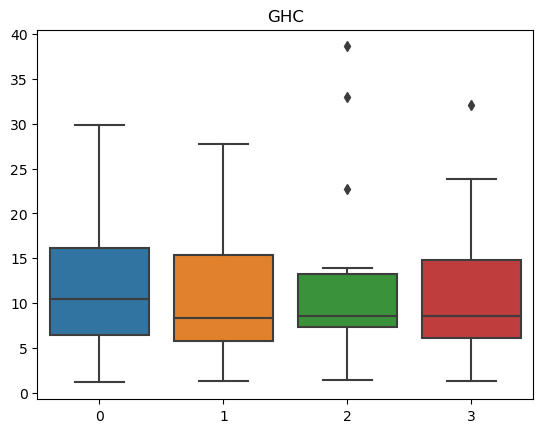

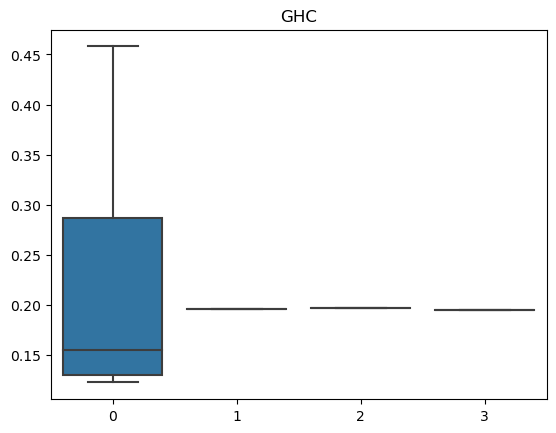

<Figure size 640x480 with 0 Axes>

In [244]:
for df, name in [(ghc_df, 'GHC'), (ge_df, 'GE'),(sc_df,'SC')]:
    print('_'*100)
    print(name)
    l_name = name.lower()
    
    df = dfs[name]
    annos = get_annos(df)
    
    ratios = {}
    counts = {}
    
    ratios['full'] = [df[anno].value_counts()[0] / df[anno].value_counts()[1] for anno in annos]
    counts['full'] = [df[anno].count() / len(df) for anno in annos]
    
    for split in ['train', 'val', 'test']:
        split_df = split_dfs[f'{split}_{l_name}']
        if name != 'SC':
            df_splitted = df[df.text.isin(split_df.text)]
        else:
            df_splitted = df[df.parent_id.isin(split_df.parent_id)]
        df_filtered = reduce_df_to_min_num_annos(df_splitted)
        
        rats = []
        for anno in annos:
            try:
                rats.append(df_filtered[anno].value_counts()[0] / df_filtered[anno].value_counts()[1])
            except:
                pass
        ratios[split] = rats
        counts[split] = [df_filtered[anno].count() / len(df_filtered) for anno in annos]
        
        print(split, sorted(df_filtered.count()))
        
    if name == 'GE':
        break
        
    sns.boxplot(list(ratios.values())).set_title(name)
    plt.figure()
    sns.boxplot(list(counts.values())).set_title(name)
    plt.figure()
        

In [259]:
df_splitted.count()

id          9956
text        9956
2           1148
4           2124
15           966
24          1101
27           997
37          1850
46           968
51           984
52          1056
60          1083
61          2009
62          1104
70          1130
81          1060
majority    9956
dtype: int64

In [262]:
reduce_df_to_min_num_annos(df_splitted).count()

id          7591
text        7591
2            966
4            966
15           966
24           966
27           966
37           966
46           966
51           966
52           966
60           966
61           966
62           966
70           966
81           966
majority    7591
dtype: int64

In [263]:
reduce_df_to_min_num_annos(df_splitted,0.5).count()

id          4028
text        4028
2            483
4            483
15           483
24           483
27           483
37           483
46           483
51           483
52           483
60           483
61           483
62           483
70           483
81           483
majority    4028
dtype: int64

In [ ]:
df_splitted

In [245]:
sorted(df_filtered.count())

[966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 7591,
 7591,
 7591]

In [254]:
m = float(df_filtered[annos[0]].count())
m

966.0

In [211]:
sc_df

,parent_id,0,1,2,3,4,5,6,7,8,...,2510,2511,2512,2513,2514,2515,2516,2517,2518,2519
0,9t4mgu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9t4u6g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9t4uue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9t4zp9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9t4zun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18447,ba9hyo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18448,ba9i2d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18449,ba9i6g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18450,ba9p9s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Comments

In [25]:
comments_df.head()

,id,parent_id,label,body,author_name
1,ei2ep1r,aypvmz,NTA,"NTA. Heh, if I were you I would have been susp...",hatgineer
3,e90cfmp,9tzn0z,NTA,NTA. #1 was plenty of reason to gracefully bow...,pastrymom
4,e90cddq,9tzn0z,NTA,NTA. A friend should care about your needs and...,glorioid
5,e90c1jo,9tzn0z,NTA,NTA. She is being incredibly immature Hit her ...,snuzet
6,e90fwxb,9tzn0z,NTA,NTA. She and her other friends are the asshole...,PremiumRecyclingBin


In [27]:
author_counts

,id,parent_id,label,body
author_name,,,,
-----_--_--,1,1,1,1
-----__--,3,3,2,3
---E,3,3,2,3
--BMO--,6,6,2,6
--Hercules--,2,2,2,2
...,...,...,...,...
zzvu,1,1,1,1
zzzkitten,4,4,1,4
zzzzbear,1,1,1,1


In [31]:
# there are some authors that commented multiple times on a post:
author_counts[author_counts.parent_id != author_counts.id]

,id,parent_id,label,body
author_name,,,,
-Chateaux-,5,4,1,5
-UnknownGeek-,63,62,2,58
-purple-is-a-fruit-,64,63,2,60
3JOH22A_asshole,4,3,1,4
52496234620,4,3,1,3
...,...,...,...,...
xX_Y33tboi_Xx,3,2,2,3
xYokai,11,10,2,10
yeaigetit,4,3,1,4


In [32]:
sns.set(rc={'figure.figsize':(5,3)})

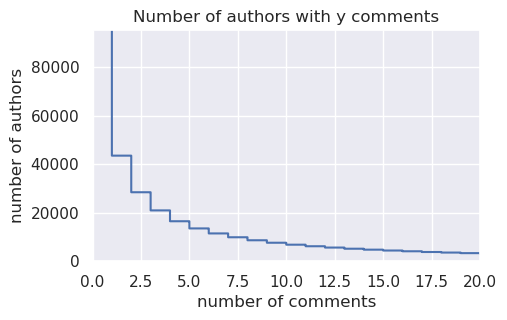

In [33]:
ax = sns.ecdfplot(data=author_counts, x='parent_id', complementary=True, stat='count')
ax.set(title='Number of authors with y comments', xlabel='number of comments', ylabel='number of authors', xlim=(0,20)) 
plt.show()

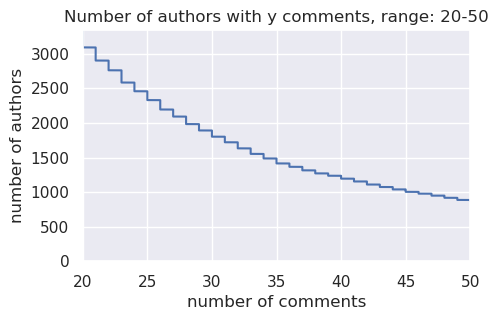

In [34]:
l,r = 20,50
ax = sns.ecdfplot(data=author_counts[author_counts.parent_id>=l], x='parent_id', complementary=True, stat='count')
ax.set(title=f'Number of authors with y comments, range: {l}-{r}', xlabel='number of comments', ylabel='number of authors', xlim=(l,r)) 
plt.show()

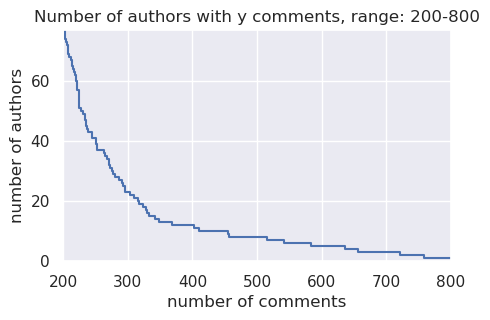

In [35]:
l,r = 200,800
ax = sns.ecdfplot(data=author_counts[author_counts.parent_id>=l], x='parent_id', complementary=True, stat='count')
ax.set(title=f'Number of authors with y comments, range: {l}-{r}', xlabel='number of comments', ylabel='number of authors', xlim=(l,r)) 
plt.show()

<AxesSubplot: xlabel='id'>

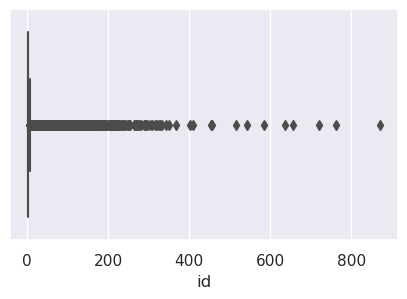

In [36]:
sns.boxplot(data=author_counts, x='id')

In [54]:
comments_df

,id,parent_id,label,body,author_name
1,ei2ep1r,aypvmz,NTA,"NTA. Heh, if I were you I would have been susp...",hatgineer
3,e90cfmp,9tzn0z,NTA,NTA. #1 was plenty of reason to gracefully bow...,pastrymom
4,e90cddq,9tzn0z,NTA,NTA. A friend should care about your needs and...,glorioid
5,e90c1jo,9tzn0z,NTA,NTA. She is being incredibly immature Hit her ...,snuzet
6,e90fwxb,9tzn0z,NTA,NTA. She and her other friends are the asshole...,PremiumRecyclingBin
...,...,...,...,...,...
446896,ei9ihtq,azofrl,NTA,NTA. She brought this up. It isn't as if you w...,UberDuperDrew
446897,ei9iz9r,azofrl,NTA,NTA..I don't know why all the other comments s...,crade1zc
446898,ei9j54d,azofrl,NTA,NTA. Boys will be boys.,XxXxFORTNITExXxX
446900,ei9xuo3,azofrl,NTA,NTA dump her bro lol,frm420


## Posts

In [62]:
posts_count

,id,label,body,author_name
parent_id,,,,
9t4fx2,2,1,2,2
9t4g7m,2,1,2,2
9t4mgu,1,1,1,1
9t4q3q,7,1,7,7
9t4u6g,4,1,4,4
...,...,...,...,...
ba9i6g,4,1,4,4
ba9iij,1,1,1,1
ba9m9f,2,1,2,2


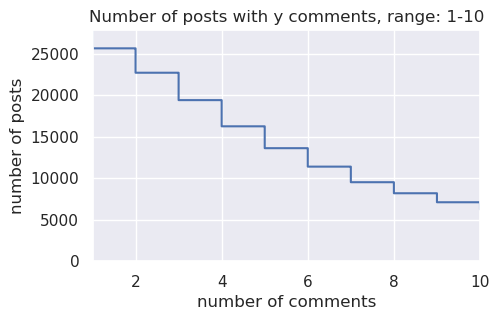

In [70]:
l,r = 1,10
ax = sns.ecdfplot(data=posts_count[posts_count.author_name>=l], x='author_name', complementary=True, stat='count')
ax.set(title=f'Number of posts with y comments, range: {l}-{r}', xlabel='number of comments', ylabel='number of posts', xlim=(l,r))
plt.show()

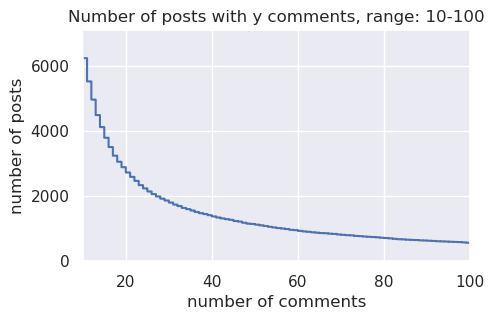

In [71]:
l,r = 10,100
ax = sns.ecdfplot(data=posts_count[posts_count.author_name>=l], x='author_name', complementary=True, stat='count')
ax.set(title=f'Number of posts with y comments, range: {l}-{r}', xlabel='number of comments', ylabel='number of posts', xlim=(l,r))
plt.show()

In [ ]:
k = 100
l = 3
p = posts_df.copy()
c = comments_df.copy()

c_l = len(c)
p_l = len(p)

is_change = True

while is_change:
    print('_'*30)
    author_counts =  c.groupby('author_name').nunique()
    #posts_count  = c.groupby('parent_id').nunique()

    author_indeicies = author_counts[author_counts.parent_id>=k].index
    c = c[c.author_name.isin(author_indeicies)]
    
    print(c.shape)

    #author_counts =  c.groupby('author_name').nunique()
    posts_count  = c.groupby('parent_id').nunique()
    c = c[c.parent_id.isin(posts_count[posts_count.author_name>=l].index)]

    print(c.shape)
    print(len(c.groupby('author_name').nunique()['parent_id']))

    is_change = c_l > len(c)
    c_l = len(c)
